In [1]:
import pickle
import string
from abc import ABC, abstractmethod
from math import ceil

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.ticker import FixedLocator
from sklearn.metrics import roc_curve
from treeple.datasets import make_trunk_mixture_classification

from gauss_mix import generate_gauss_mix

In [2]:
sns.set(color_codes=True, style="ticks", context="talk", font_scale=1.5)
PALETTE = sns.color_palette("Set1")
sns.set_palette(PALETTE[1:5] + PALETTE[6:], n_colors=9)

In [3]:
COMMON_CLFS = {
    "KNN" : {"color" : "#a65628"},
    "LR" : {"color" : "#ff7f00"},
    "SVM" : {"color" : "#4daf4a"},
    "RF" : {"color" : "#377eb8"},
    "MIGHT" : {"color" : "#e41a1c", "lw" : 3},
}

ALL_CLFS = {
    "S@98" : COMMON_CLFS,
    "Mutual Information" : dict(COMMON_CLFS, KSG={"color" : "#f781bf"}),
    "AUC" : COMMON_CLFS,
    "Power" : dict(COMMON_CLFS)
}

FILE_METRICS = {
    "S@98": "S98",
    "Mutual Information" : "MI",
    "AUC" : "AUC",
    "Power" : "power"
}

COLUMN_ORDER = [
    "S@98",
    "AUC",
    # "Mutual Information",
    "Power"
]

In [4]:
# class PlotFigures(ABC):
#     def __init__(self, simulation_name, simulation_kwargs=None, roc_iterations=100, truths=None, simulation_ticks=[-3, 0, 3]):
#         self.simulation_name = simulation_name
#         self.simulation_kwargs = simulation_kwargs
#         self.roc_iterations = roc_iterations
#         self.truths = truths
#         self.simulation_ticks = simulation_ticks
#         self.chance = {
#             "S@98" : 0.02,
#             "AUC": 0.5,
#             "Mutual Information": 0,
#             "Power" : 0.05,
#         }

#     def plot_figure(self):
#         # define figure attributes
#         fig = plt.figure(figsize=(18, 18), constrained_layout=True)
#         self.ncols = 3
#         subfigs = fig.subfigures(3, 1, hspace=0.1)
#         subfigs_top = subfigs[0].subfigures(1, 2, width_ratios=[2.5, 1], wspace=0.1)
#         axs_sims = subfigs_top[0].subplots(1, 2)
#         axs_roc = subfigs_top[1].subplots(1, 1)
#         axs_inc_n = subfigs[1].subplots(1, 3)
#         axs_inc_d = subfigs[2].subplots(1, 3)
#         self.axes = [*axs_sims, axs_roc, *axs_inc_n, *axs_inc_d]
        
#         self.plot_simulations()
#         self.plot_roc()
#         self.plot_metrics_power()

#         # misc section titles
#         subfigs_top[0].suptitle(f"{self.simulation_name.capitalize()} simulation up to 4096 variables")
#         axs_roc.set_title("ROC curve for 4096 variables and\n256 samples", fontsize='large')
#         subfigs[1].suptitle("Statistical estimates for 4096 variables")
#         subfigs[2].suptitle("Statistical estimates for 256 samples")

#         # add lettering
#         for i, ax in enumerate(self.axes):
#             ax.set_title(
#                 string.ascii_uppercase[i], loc="left", weight="bold"
#             )
#             ax.spines['top'].set_visible(False)
#             ax.spines['right'].set_visible(False)

#         # add legends
#         leg_sims = fig.legend(
#             *self.axes[1].get_legend_handles_labels(),
#             loc="upper left",
#             ncol=1,
#             bbox_to_anchor=(0.17, 0.98),
#             fontsize=20,
#         )
#         leg_roc = fig.legend(
#             handles=self.axes[2].get_legend_handles_labels()[0][::-1],# + [self.axes[5].get_legend_handles_labels()[0][-1]],
#             labels=self.axes[2].get_legend_handles_labels()[1][::-1],# + [self.axes[5].get_legend_handles_labels()[1][-1]],
#             # *self.axes[2].get_legend_handles_labels(),
#             loc="lower center",
#             ncol=len(self.axes[2].get_legend_handles_labels()[1]) + 1,
#             bbox_to_anchor=(0.5, -0.1),
#             # columnspacing=4.0
#         )
#         # leg_mi = fig.legend(
#         #     handles=[self.axes[6].get_legend_handles_labels()[0][-1]],
#         #     labels=[self.axes[6].get_legend_handles_labels()[1][-1]],
#         #     loc="lower center",
#         #     ncol=1,
#         #     bbox_to_anchor=(0.741, -0.13)
#         # )
#         # leg_power = fig.legend(
#         #     handles=[self.axes[5].get_legend_handles_labels()[0][-1]],
#         #     labels=[self.axes[5].get_legend_handles_labels()[1][-1]],
#         #     loc="lower center",
#         #     ncol=1,
#         #     bbox_to_anchor=(0.873, -0.16)
#         # )
#         # for leg in [leg_sims, leg_roc, leg_mi, leg_power]:
#         for leg in [leg_sims, leg_roc]:
#             leg.get_frame().set_linewidth(0)
#             for legobj in leg.legend_handles:
#                 legobj.set_linewidth(5.0)

#         plt.savefig(f"figs/might_{self.simulation_name}_appendix.pdf", transparent=True, bbox_inches='tight')
#         plt.show()

#     def plot_simulations(self, n=50):
#         pdf = self._generate_data(n, **self.simulation_kwargs)[-1]
#         pdf_noise = self._generate_data(n, mu_class1=0)[-1]

#         for i, plot_pdf in enumerate([pdf, pdf_noise]):
#             sns.lineplot(
#                 plot_pdf,
#                 x="x",
#                 y="pdf_class1",
#                 color="#bdbdbd",
#                 ax=self.axes[i],
#                 label="Case",
#                 linestyle='solid',
#                 legend=False,
#                 lw=5
#             )
#             sns.lineplot(
#                 plot_pdf,
#                 x="x",
#                 y="pdf_class0",
#                 color="black",
#                 ax=self.axes[i],
#                 label="Control",
#                 linestyle=(0, (5, 5)),
#                 legend=False,
#                 lw=5
#             )

#         # make plot look pretty
#         self.axes[0].set(
#             xlabel="Variable 1",
#             ylabel="Distribution",
#             xticks=self.simulation_ticks,
#             yticks=[],
#             ylim=[0, 0.5],
#         )
#         self.axes[1].set(
#             xlabel="Variables 2 to 4096",
#             ylabel="",
#             xticks=[-3, 0, 3],
#             yticks=[],
#             ylim=[0, 0.5],
#         )

#         # simulated_df = pd.DataFrame(dict(x=x.ravel(), x_noise=x_noise.ravel(), hue=np.tile([0, 1], n // 2)))
#         # sns.scatterplot(simulated_df, x="x", y="x_noise", hue="hue", ax=self.axes[2], palette=["black", "#969696"], legend=False)

#         # # make plot look pretty
#         # self.axes[2].set(
#         #     xlabel="Variable 1",
#         #     ylabel="Other Variables",
#         #     xticks=self.simulation_ticks,
#         #     yticks=[-3, 0, 3]
#         # )

#     @staticmethod
#     def _generate_data(n=256, **kwargs):
#         return generate_gauss_mix(
#             N=n,
#             **kwargs,
#         )

#     def plot_roc(self):
#         # compute true fpr, tpr, and thresholds and plot the ROC
#         x, y, posterior, *_ = self._generate_data(n=50000, **self.simulation_kwargs)
#         true_fpr, true_tpr, true_thresholds = roc_curve(
#             y, posterior, pos_label=1, drop_intermediate=False
#         )
#         # self.axes[2].plot([0, 1], [0, 1], linestyle="--", color="black", alpha=0.5),
#         self.axes[2].plot(true_fpr, true_tpr, color="black")#, label="Truth")
        
#         # load all other classifier ROC data and plot ROC curves
#         base_fpr = np.linspace(0, 1, 1001)
#         for clf_name, plot_kwargs in COMMON_CLFS.items():
#             try:
#                 with open(f"fig1_v2_results/fpr_{self.simulation_name}_{clf_name}.pkl", "rb") as f:
#                     clf_fpr = pickle.load(f)
#             except FileNotFoundError:
#                 print(f"fig1_v2_results/fpr_{self.simulation_name}_{clf_name}.pkl is missing")
#                 continue
#             try:
#                 with open(f"fig1_v2_results/tpr_{self.simulation_name}_{clf_name}.pkl", "rb") as f:
#                     clf_tpr = pickle.load(f)
#             except FileNotFoundError:
#                 print(f"fig1_v2_results/tpr_{simulation_name}_{clf_name}.pkl is missing")
#                 continue
#             clf_tprs = []
#             for i in range(self.roc_iterations):
#                 try:
#                     clf_tprs.append(np.interp(base_fpr, clf_fpr[i], clf_tpr[i]))
#                 except IndexError:
#                     break
#             mean_clf_tpr = np.mean(clf_tprs, axis=0)
#             self.axes[2].plot(base_fpr, mean_clf_tpr, **plot_kwargs, label=clf_name)

#         # make plot look pretty
#         self.axes[2].set(
#             xlabel="False Positive Rate",
#             ylabel="True Positive Rate",
#             xticks=[0, 1],
#             yticks=[0, 1],
#             xlim=[0, 1],
#             ylim=[0, 1]
#         )

#     def plot_metrics_power(self):
#         for i, ax in enumerate(self.axes[self.ncols:]):
#             c = i % self.ncols
#             metric = COLUMN_ORDER[c]

#             if i // self.ncols == 0:
#                 xs = [128, 256, 512, 1024]#, 2048, 4096]
#                 n_or_d = "n"
#             else:
#                 xs = [2**i for i in range(2, 13)]
#                 n_or_d = "d"

#             ax.axhline(
#                 y=self.chance[metric],
#                 color="#969696",
#                 lw=3,
#                 xmax=0.95,
#                 linestyle="dashed",
#             )

#             if metric != "Power":
#             #     ax.axhline(
#             #         y=0.05,
#             #         linestyle=":",
#             #         color="black",
#             #         label="Alpha",
#             #     )
#             # else:
#                 ax.axhline(
#                     y=self.truths[metric],
#                     color="black",
#                     lw=3,
#                     xmax=0.95,
#                 )

#             for i, (test, plot_kwargs) in enumerate(ALL_CLFS[metric].items()):
#                 file_test = test if test != "MIGHT" else test.lower()
#                 if metric == "Power" and test == "MIGHT":
#                     file_test += "-S98"
#                 try:
#                     ys = np.genfromtxt(
#                         f"results/{self.simulation_name}-{file_test}-{FILE_METRICS[metric]}-vs-{n_or_d}.csv", delimiter=","
#                     )
#                 except FileNotFoundError:
#                     print(f"results/{self.simulation_name}-{file_test}-{FILE_METRICS[metric]}-vs-{n_or_d}.csv is missing")
#                     continue
#                 if metric == "Power":
#                     ys = np.array([y if y > 0 else 0 for y in ys])
#                     if n_or_d == "n" and test in ["MIGHT", "Dcorr", "Dcorr_PCA"]:
#                         ys = ys[1:-2]
#                     elif n_or_d == "n":
#                         ys = ys[:-2]
#                     if test == "Dcorr_PCA":
#                         test = "Dcorr-PCA"
#                     ax.plot(xs, ys, **plot_kwargs, label=test)
#                 else:
#                     quantiles = []
#                     for quantile in [0.25, 0.5, 0.75]:
#                         quartile = np.quantile(ys, quantile, axis=1)
#                         quartile = np.array([y if y > 0 else 0 for y in quartile])
#                         quartile = quartile[:-2] if n_or_d == "n" else quartile
#                         if test == "MIGHT" and n_or_d == "n":
#                             quartile = quartile[1:]
#                         quantiles.append(quartile)
#                     ax.plot(xs, quantiles[1], **plot_kwargs, label=test)
#                     ax.fill_between(
#                         xs,
#                         quantiles[0],
#                         quantiles[2],
#                         alpha=0.2,
#                         color=plot_kwargs["color"],
#                     )
        
#             # make plot pretty
#             ax.set(
#                 # xscale="log" if metric == "Power" and n_or_d == "n" else "linear",
#                 xlabel = (
#                     "Sample Size" if n_or_d == "n"
#                     else "# of Variables"
#                 ),
#                 ylim=(
#                     [0, 0.286] if metric == "S@98"
#                     else [0.5, 0.64] if metric == "AUC"
#                     else [0, 1.01]
#                     # else [0.5, (self.truths[metric] - 0.5) / 0.13 * 0.01 + self.truths[metric]] if metric == "AUC"
#                     # else [0, 1.1 * self.truths[metric]]
#                 ),
#                 yticks=(
#                     # [0, 1] if metric == "Power"
#                     # else [0, 0.5, 1] if self.simulation_name == "independent" and metric == "AUC"
#                     # else [0, self.truths[metric], 0.1] if self.simulation_name == "independent"
#                     # else [0.5, self.truths[metric]] if metric == "AUC"
#                     # else [0, self.truths[metric]]
#                     [0.05] if metric == "Power" and self.simulation_name == "independent"
#                     else [0.05, 1] if metric == "Power"
#                     else [self.chance[metric], self.truths[metric]]
#                 ),
#                 yticklabels=(
#                     ["Perfect/\nChance"] if self.simulation_name == "independent" and metric == "Power"
#                     else ["", "Truth/\nChance"] if self.simulation_name == "independent"
#                     else ["Chance", "Perfect"] if metric == "Power"
#                     else ["Chance", "Truth"]
#                 ),
#                 ylabel=f"{metric}"
#             )
#             ax.xaxis.set_minor_locator(FixedLocator(xs))
#             ax.xaxis.set_major_locator(FixedLocator(
#                 [128, 512, 1024] if n_or_d == "n"
#                 else [4, 2048, 4096]
#             ))
#             # ax.xaxis.set_major_formatter(ScalarFormatter())
#             # ax.xaxis.set_minor_formatter(NullFormatter())

In [5]:
# class PlotNonlinearFigure(PlotFigures):
#     def __init__(self):
#         super().__init__(
#             simulation_name="nonlinear",
#             simulation_kwargs=dict(split_class1=(0.75, 0.25)),
#             truths={
#                 "S@98" : 0.26,
#                 "AUC": 0.63,
#                 "Mutual Information": 0.09,
#             },
#             simulation_ticks=[-3, 0, 3, 6]
#         )

#     def __call__(self):
#         self.plot_figure()

# nonlinear_figure = PlotNonlinearFigure()
# nonlinear_figure()

In [6]:
# class PlotIndependentFigure(PlotFigures):
#     def __init__(self):
#         super().__init__(
#             simulation_name="independent",
#             simulation_kwargs=dict(split_class0=(0.75, 0.25), split_class1=(0.75, 0.25)),
#             truths={
#                 "S@98" : 0.02,
#                 "AUC": 0.5,
#                 "Mutual Information": 0,
#             },
#             simulation_ticks=[-3, 0, 3, 6]
#         )

#     def __call__(self):
#         self.plot_figure()

# independent_figure = PlotIndependentFigure()
# independent_figure()

In [7]:
# class PlotLinearFigure(PlotFigures):
#     def __init__(self):
#         super().__init__(
#             simulation_name="linear",
#             simulation_kwargs={},
#             truths={
#                 "S@98" : 0.14,
#                 "AUC": 0.76,
#                 "Mutual Information": 0.11,
#             }
#         )

#     def __call__(self):
#         self.plot_figure()

# linear_figure = PlotLinearFigure()
# linear_figure()

In [8]:
CONDITIONAL_COMMON_CLFS = {
    "KNN" : {"color" : "#a65628"},
    "LR" : {"color" : "#ff7f00"},
    "SVM" : {"color" : "#4daf4a"},
    "RF" : {"color" : "#377eb8"},
    "CoMIGHT" : {"color" : "#e41a1c", "lw" : 3},
}

CONDITIONAL_ALL_CLFS = {
    "S@98" : CONDITIONAL_COMMON_CLFS,
    "CMI" : dict(CONDITIONAL_COMMON_CLFS, KSG={"color" : "#f781bf"}),
    "AUC" : CONDITIONAL_COMMON_CLFS,
    "Power" : dict(CONDITIONAL_COMMON_CLFS)
}

CONDITIONAL_FILE_METRICS = {
    "S@98": "sas98",
    "AUC" : "AUC",
}

CONDITIONAL_FILE_SIMS = {
    "linear": "mean_shiftv4",
    "nonlinear" : "multi_modalv3",
    "independent" : "multi_equalv2",
}

CONDITIONAL_COLUMN_ORDER = [
    "S@98",
    "AUC",
    # "CMI",
    "Power"
]

In [9]:
# class PlotConditionalFigures(ABC):
#     def __init__(self, simulation_name, simulation_kwargs=None, roc_iterations=100, truths=None, simulation_ticks=[-3, 0, 3]):
#         self.simulation_name = simulation_name
#         self.simulation_kwargs = simulation_kwargs
#         self.roc_iterations = roc_iterations
#         self.truths = truths
#         self.simulation_ticks = simulation_ticks
#         self.chance = {
#             "S@98" : 0.02,
#             "AUC": 0.5,
#             "Mutual Information": 0,
#             "Power" : 0.05,
#         }

#     def plot_figure(self):
#         # define figure attributes
#         fig = plt.figure(figsize=(18, 18), constrained_layout=True)
#         self.ncols = 3
#         subfigs = fig.subfigures(3, 1, hspace=0.1)
#         subfigs_top = subfigs[0].subfigures(1, 2, width_ratios=[2.5, 1], wspace=0.2)
#         axs_sims = subfigs_top[0].subplots(1, 2)
#         axs_roc = subfigs_top[1].subplots(1, 1)
#         axs_inc_n = subfigs[1].subplots(1, 3)
#         axs_inc_d = subfigs[2].subplots(1, 3)
#         self.axes = [*axs_sims, axs_roc, *axs_inc_n, *axs_inc_d]
        
#         self.plot_simulations()
#         self.plot_roc()
#         self.plot_metrics_power()

#         # misc section titles
#         subfigs_top[0].suptitle(f"{self.simulation_name.capitalize()} simulation with two variable sets")
#         axs_roc.set_title("ROC curve for 4096 total variables and\n256 samples", fontsize='large')
#         subfigs[1].suptitle("Statistical estimates for 4096 total variables")
#         subfigs[2].suptitle("Statistical estimates for 256 samples")

#         # add lettering
#         for i, ax in enumerate(self.axes):
#             ax.set_title(
#                 string.ascii_uppercase[i], loc="left", weight="bold"
#             )
#             ax.spines['top'].set_visible(False)
#             ax.spines['right'].set_visible(False)

#         # add legends
#         # leg_sims = fig.legend(
#         #     *self.axes[1].get_legend_handles_labels(),
#         #     loc="upper left",
#         #     ncol=1,
#         #     bbox_to_anchor=(0.17, 0.95),
#         #     fontsize=20,
#         #     labels=["Case", "Control"]
#         # )
#         leg_roc = fig.legend(
#             handles=self.axes[2].get_legend_handles_labels()[0][::-1] if self.simulation_name == "nonlinear" else self.axes[3].get_legend_handles_labels()[0][::-1],
#             labels=self.axes[2].get_legend_handles_labels()[1][::-1] if self.simulation_name == "nonlinear" else self.axes[3].get_legend_handles_labels()[1][::-1],
#             loc="lower center",
#             ncol=len(self.axes[2].get_legend_handles_labels()[1]) + 1 if self.simulation_name == "nonlinear" else len(self.axes[3].get_legend_handles_labels()[1]) + 1,
#             bbox_to_anchor=(0.5, -0.1),
#             # columnspacing=4.0
#         )
#         # leg_mi = fig.legend(
#         #     handles=[self.axes[6].get_legend_handles_labels()[0][-1]],
#         #     labels=[self.axes[6].get_legend_handles_labels()[1][-1]],
#         #     loc="lower center",
#         #     ncol=1,
#         #     bbox_to_anchor=(0.741, -0.13)
#         # )
#         # leg_power = fig.legend(
#         #     handles=[self.axes[5].get_legend_handles_labels()[0][-1]],
#         #     labels=[self.axes[5].get_legend_handles_labels()[1][-1]],
#         #     loc="lower center",
#         #     ncol=1,
#         #     bbox_to_anchor=(0.873, -0.16)
#         # )
#         # for leg in [leg_sims, leg_roc, leg_mi, leg_power]:
#         for leg in [leg_roc]:
#             leg.get_frame().set_linewidth(0)
#             for legobj in leg.legend_handles:
#                 legobj.set_linewidth(5.0)

#         plt.savefig(f"figs/comight_{self.simulation_name}_appendix.pdf", transparent=True, bbox_inches='tight')
#         plt.show()

#     def plot_simulations(self, n=512):
#         # pdf = self._generate_data(n, **self.simulation_kwargs)[-1]
#         # pdf_noise = self._generate_data(n, mu_class1=0)[-1]

#         # for i, plot_pdf in enumerate([pdf, pdf_noise]):
#         #     sns.lineplot(
#         #         plot_pdf,
#         #         x="x",
#         #         y="pdf_class1",
#         #         color="#bdbdbd",
#         #         ax=self.axes[i],
#         #         label="Case",
#         #         linestyle='solid',
#         #         legend=False,
#         #         lw=5
#         #     )
#         #     sns.lineplot(
#         #         plot_pdf,
#         #         x="x",
#         #         y="pdf_class0",
#         #         color="black",
#         #         ax=self.axes[i],
#         #         label="Control",
#         #         linestyle=(0, (5, 5)),
#         #         legend=False,
#         #         lw=5
#         #     )

#         # # make plot look pretty
#         # self.axes[0].set(
#         #     xlabel="Variable 1 in Sets A/B",
#         #     ylabel="Distribution",
#         #     xticks=self.simulation_ticks,
#         #     yticks=[],
#         #     ylim=[0, 0.5]
#         # )
#         # self.axes[1].set(
#         #     xlabel="Other variables in Sets A/B",
#         #     ylabel="",
#         #     xticks=[-3, 0, 3],
#         #     yticks=[],
#         #     ylim=[0, 0.5]
#         # )

#         if self.simulation_name == "nonlinear":
#             v1, v2, y = self.make_multi_modal()
#         else:
#             v1, v2, y = self.make_multi_equal()
#         simulated_df = pd.DataFrame(dict(
#             s1v1=v1[:, 0],
#             s2v1=v2[:, 0],
#             s1v2=v1[:, 1],
#             s2v2=v2[:, 1],
#             hue=y.ravel(),
#         ))
#         scatter = sns.scatterplot(
#             simulated_df,
#             x="s1v1",
#             y="s2v1",
#             hue="hue",
#             ax=self.axes[0],
#             palette=["black", "#bdbdbd"],
#             style="hue",
#             markers=['.', '*'],
#             legend=True,
#         )
#         scatter.legend(
#             title=False,
#             frameon=False,
#             loc="upper right",
#             ncol=1,
#             # bbox_to_anchor=(0.17, 0.95),
#             fontsize=20,
#             handles=self.axes[0].get_legend_handles_labels()[0],
#             labels=["Control", "Case"],
#             markerscale=2
#         )
#         sns.scatterplot(
#             simulated_df,
#             x="s1v2",
#             y="s2v2",
#             hue="hue",
#             ax=self.axes[1],
#             palette=["black", "#bdbdbd"],
#             style="hue",
#             markers=['.', '*'],
#             legend=False
#         )

#         # # make plot look pretty
#         self.axes[0].set(
#             xlabel="Set A Variable 1",
#             ylabel="Set B Variable 1",
#             xticks=self.simulation_ticks,
#             yticks=[-3, 0, 3] if self.simulation_name == "nonlinear" else [-3, 0, 3, 6],
#             xlim=[-5, 10],
#             ylim=[-5, 5] if self.simulation_name == "nonlinear" else [-5, 10],
#         )
#         self.axes[1].set(
#             xlabel="Set A Variables 2 to 4093",
#             ylabel="Set B Variables 2 and 3",
#             xticks=self.simulation_ticks,
#             yticks=[-3, 0, 3],
#             xlim=[-5, 5],
#             ylim=[-5, 5]
#         )

#     @staticmethod
#     def make_multi_modal(
#         n_samples=256,
#         n_dim_1=2,
#         mu_viewone=5,
#         mu_viewtwo=1,
#         mix=0.75,
#         rho=0.2,
#         seed=None,
#         n_dim_2=2,
#     ):
#         """Make multi-modal binary classification data."""
#         rng = np.random.default_rng(seed)
    
#         method = "svd"
#         mu_1_vec = np.array([mu_viewone, mu_viewtwo])
#         mu_0_vec = np.array([0, 0])
#         cov = np.array([[1.5, rho], [rho, 1.5]])
    
#         mixture_idx = rng.choice(2, n_samples // 2, replace=True, shuffle=True, p=[mix, 1 - mix])  # type: ignore
#         norm_params = [[mu_0_vec, np.eye(2)], [mu_1_vec, cov]]
#         X_mixture = np.fromiter(
#             (
#                 rng.multivariate_normal(*(norm_params[i]), size=1, method=method)
#                 for i in mixture_idx
#             ),
#             dtype=np.dtype((float, 2)),
#         )
    
#         X = np.vstack(
#             (
#                 rng.multivariate_normal(np.zeros(2), cov, n_samples // 2, method=method),
#                 X_mixture.reshape(n_samples // 2, 2),
#             )
#         )
    
#         assert X.shape[1] == 2
#         view_1 = X[:, (0,)]
#         view_1 = np.hstack(
#             (view_1, rng.normal(loc=0, scale=1, size=(X.shape[0], n_dim_1 - 1)))
#         )
#         view_2 = X[:, 1:]
#         # add noise to the second view so that view_2 = (n_samples, n_dim_2)
#         view_2 = np.concatenate(
#             (view_2, rng.standard_normal(size=(n_samples, n_dim_2 - view_2.shape[1]))),
#             axis=1,
#         )
    
#         X = np.concatenate((view_1, view_2), axis=1)
#         y = np.concatenate((np.zeros(n_samples // 2), np.ones(n_samples // 2)))
#         return view_1, view_2, y

#     @staticmethod
#     def make_multi_equal(
#         n_samples=256,
#         n_dim_1=2,
#         mu_0=1,
#         mu_1=5,
#         mix=0.75,
#         seed=None,
#         n_dim_2=2,
#     ):
#         """Make multi-modal binary classification data.
    
#         X comprises of [view_1, view_2] where view_1 is the first ``n_dim_1`` dimensions
#         and view_2 is the last ``n_dim_2`` dimensions.
    
#         view_1 is generated, such that [A, B] corresponding to class labels [0, 1]
#         are generated as follows:
    
#         A ~ mix * N(1, I) + (1 - mix) * N(m_factor, I)
#         B ~ mix * N(1, I) + (1 - mix) * N(m_factor, I)
    
#         view_2 is generated, such that [A, B] corresponding to class labels [0, 1]
#         are generated as follows:
    
#         A ~ mix * N(1 / np.sqrt(2), I) + (1 - mix) * N(1 / np.sqrt(2) * m_factor, I)
#         B ~ mix * N(1 / np.sqrt(2), I) + (1 - mix) * N(1 / np.sqrt(2) * m_factor, I)
    
#         Parameters
#         ----------
#         n_samples : int, optional
#             The number of samples to generate, by default 1024.
#         n_dim_1 : int, optional
#             The number of dimensions in first view, by default 4090.
#         mu_0 : int, optional
#             The mean of the first class, by default 1.
#         mu_1 : int, optional
#             The mean of the second class, by default -1.
#         seed : int, optional
#             Random seed, by default None.
#         n_dim_2 : int, optional
#             The number of dimensions in second view, by default 6.
#         return_params : bool
#             Whether to return parameters of the generating model or not. Default is False.
    
#         Returns
#         -------
#         X : ArrayLike of shape (n_samples, n_dim_1 + n_dim_2)
#             Data.
#         y : ArrayLike of shape (n_samples,)
#             Labels.
#         """
#         rng = np.random.default_rng(seed)
#         default_n_informative = 2
    
#         X1, _ = make_trunk_mixture_classification(
#             n_samples=n_samples,
#             n_dim=n_dim_1 + 1,
#             n_informative=default_n_informative,
#             mu_0=mu_0,
#             mu_1=mu_1,
#             mix=mix,
#             rho=0.5,
#             seed=rng.integers(0, np.iinfo(np.int32).max),
#             return_params=False,
#         )
#         # only keep the second half of samples, corresponding to the mixture
#         X1 = X1[n_samples // 2 :, :]
    
#         X2, _ = make_trunk_mixture_classification(
#             n_samples=n_samples,
#             n_dim=n_dim_1 + 1,
#             n_informative=default_n_informative,
#             mu_0=mu_0,
#             mu_1=mu_1,
#             mix=mix,
#             rho=0.5,
#             seed=rng.integers(0, np.iinfo(np.int32).max),
#             return_params=False,
#         )
#         # only keep the second half of samples, corresponding to the mixture
#         X2 = X2[n_samples // 2 :, :]
    
#         X = np.vstack((X1, X2))
#         y = np.hstack((np.zeros(n_samples // 2), np.ones(n_samples // 2)))
    
#         # get the second informative dimension
#         view_1 = X[:, 1:]
    
#         # only take one informative dimension
#         view_2 = X[:, (0,)]
    
#         # add noise to the second view so that view_2 = (n_samples, n_dim_2)
#         view_2 = np.concatenate(
#             (view_2, rng.standard_normal(size=(n_samples, n_dim_2 - view_2.shape[1]))),
#             axis=1,
#         )
#         X = np.concatenate((view_1, view_2), axis=1)
#         return view_1, view_2, y

#     def plot_roc(self):
#         # compute true fpr, tpr, and thresholds and plot the ROC
#         with open(f"fig1_v2_results/fpr_{self.simulation_name}_truth.pkl", "rb") as f:
#             true_fpr = pickle.load(f)
#         with open(f"fig1_v2_results/tpr_{self.simulation_name}_truth.pkl", "rb") as f:
#             true_tpr = pickle.load(f)
#         # self.axes[2].plot([0, 1], [0, 1], linestyle="--", color="black", alpha=0.5),
#         self.axes[2].plot(true_fpr, true_tpr, color="black")#, label="Truth")
        
#         # load all other classifier ROC data and plot ROC curves
#         if self.simulation_name == "nonlinear":
#             # comight_clf_roc = np.load(
#             #     "fig1_v2_results/comight_multimodal_roc_curve_512n512d.npz",
#             #     allow_pickle=True
#             # )
#             # other_clf_roc = np.load(
#             #     "fig1_v2_results/comparators_multimodal_roc_curve_512n512d.npz",
#             #     allow_pickle=True
#             # )
#             base_fpr = np.linspace(0, 1, 1001)
#             for clf_name in CONDITIONAL_COMMON_CLFS.keys():
#                 clf_roc = np.load(
#                     f"fig1_v2_results/{clf_name.lower()}_multimodal_roc_curve_256n4096d-mu2=5.npz",
#                     allow_pickle=True
#                 )
#                 clf_fprs, clf_tprs = clf_roc["clf_fprs"], clf_roc["clf_tprs"]
#                 plot_clf_tprs = []
#                 for clf_fpr, clf_tpr in zip(clf_fprs, clf_tprs):
#                     plot_clf_tprs.append(np.interp(base_fpr, clf_fpr, clf_tpr))
#                 mean_clf_tpr = np.mean(plot_clf_tprs, axis=0)
#                 self.axes[2].plot(base_fpr, mean_clf_tpr, **CONDITIONAL_COMMON_CLFS[clf_name], label=clf_name)
#         else:
#             comight_clf_roc = np.load(
#                 "fig1_v2_results/comight_multiequal_roc_curve_512n512d.npz",
#                 allow_pickle=True
#             )
#             other_clf_roc = np.load(
#                 "fig1_v2_results/comparators_multiequal_roc_curve_512n512d.npz",
#                 allow_pickle=True
#             )
#             base_fpr = np.linspace(0, 1, 1001)
    
#             # Plot comparators
#             all_clf_fprs, all_clf_tprs = other_clf_roc["all_clf_fprs"], other_clf_roc["all_clf_tprs"]
#             plot_clf_tprs = []
#             for clf_fprs, clf_tprs, clf_name in zip(all_clf_fprs, all_clf_tprs, ["RF", "KNN", "SVM", "LR"]):
#                 if clf_name == "CoMIGHT":
#                     continue
#                 plot_clf_tprs = []
#                 for clf_fpr, clf_tpr in zip(clf_fprs, clf_tprs):
#                     plot_clf_tprs.append(np.interp(base_fpr, clf_fpr, clf_tpr))
#                 mean_clf_tpr = np.mean(plot_clf_tprs, axis=0)
#                 self.axes[2].plot(base_fpr, mean_clf_tpr, **CONDITIONAL_COMMON_CLFS[clf_name], label=clf_name)
    
#             # Plot CoMIGHT
#             clf_fprs, clf_tprs = comight_clf_roc["clf_fprs"], comight_clf_roc["clf_tprs"]
#             plot_clf_tprs = []
#             for clf_fpr, clf_tpr in zip(clf_fprs, clf_tprs):
#                 plot_clf_tprs.append(np.interp(base_fpr, clf_fpr, clf_tpr))
#             mean_clf_tpr = np.mean(plot_clf_tprs, axis=0)
#             self.axes[2].plot(base_fpr, mean_clf_tpr, **CONDITIONAL_COMMON_CLFS["CoMIGHT"], label="CoMIGHT")

#         # make plot look pretty
#         self.axes[2].set(
#             xlabel="False Positive Rate",
#             ylabel="True Positive Rate",
#             xticks=[0, 1],
#             yticks=[0, 1],
#             xlim=[0, 1],
#             ylim=[0, 1]
#         )

#     def plot_metrics_power(self):
#         for i, ax in enumerate(self.axes[self.ncols:]):
#             c = i % self.ncols
#             metric = CONDITIONAL_COLUMN_ORDER[c]
#             if metric != "Power":
#             #     ax.axhline(
#             #         y=0.05,
#             #         linestyle=":",
#             #         color="black",
#             #         label="Alpha",
#             #     )
#             # else:
#                 ax.axhline(
#                     y=self.truths[metric],
#                     color="black",
#                     lw=3,
#                     xmax=0.95,
#                 )
 
#             if self.simulation_name != "independent":
#                 ax.axhline(
#                     y=self.chance[metric],
#                     color="#969696",
#                     lw=3,
#                     xmax=0.95,
#                     linestyle="dashed",
#                 )

#             if i // self.ncols == 0:
#                 xs = [256, 512, 1024]#, 2048, 4096]
#                 n_or_d = "nsamples"
#                 samp_or_dim = 4093 if self.simulation_name == "nonlinear" else 506
#             else:
#                 xs = [2**i for i in range(3, 11)]
#                 n_or_d = "ndims"
#                 samp_or_dim = 256 if self.simulation_name == "nonlinear" else 506
#             for i, (test, plot_kwargs) in enumerate(CONDITIONAL_ALL_CLFS[metric].items()):
#                 file_test = test.lower()
#                 if metric == "Power":
#                     # if test == "CoMIGHT":
#                     #     try:
#                     #         ys_df = pd.read_csv(
#                     #             f"results/comight/results_vs_{n_or_d}_{CONDITIONAL_FILE_SIMS[self.simulation_name]}_comight-power_{samp_or_dim}_100.csv", delimiter=","
#                     #         )
#                     #         ys_df_perm = pd.read_csv(
#                     #             f"results/comight/results_vs_{n_or_d}_{CONDITIONAL_FILE_SIMS[self.simulation_name]}_comight-permuted-power_{samp_or_dim}_100.csv", delimiter=","
#                     #         )
#                     #     except FileNotFoundError:
#                     #         print(f"results/comight/results_vs_{n_or_d}_{CONDITIONAL_FILE_SIMS[self.simulation_name]}_comight-permuted-power_{samp_or_dim}_100.csv is missing")
#                     #         continue
#                     #     stat = "sas98"
#                     # else:
#                     try:
#                         ys_df = pd.read_csv(
#                             f"results/comight/results_vs_{n_or_d}_{CONDITIONAL_FILE_SIMS[self.simulation_name]}_{file_test}_sas98_{samp_or_dim}_100.csv", delimiter=","
#                         )
#                         ys_df_perm = pd.read_csv(
#                             f"results/comight/results_vs_{n_or_d}_{CONDITIONAL_FILE_SIMS[self.simulation_name]}_{test.lower()}-power_{samp_or_dim}_100.csv", delimiter=","
#                         )
#                     except FileNotFoundError:
#                         print(f"results/comight/results_vs_{n_or_d}_{CONDITIONAL_FILE_SIMS[self.simulation_name]}_{test.lower()}-power_{samp_or_dim}_100.csv is coming")
#                         continue
#                     if self.simulation_name == "independent":
#                         stat = "sas98"
#                     else:
#                         stat = "metric_value"
#                     col_name = "n_dims_1" if n_or_d == "ndims" else "n_samples"
#                     ys = []
#                     dims_or_samps = set(ys_df[col_name])
#                     for x in dims_or_samps:
#                         threshold = np.percentile(ys_df_perm["sas98"], 95)
#                         count = ys_df_perm[ys_df_perm[col_name] == x].shape[0]
#                         filtered_df1 = ys_df[
#                             (ys_df[stat] >= threshold) & (ys_df[col_name] == x)
#                         ]
#                         ys.append((1 + len(filtered_df1)) / (1 + count))
#                 else:
#                     try:
#                         ys_df = pd.read_csv(
#                             f"results/comight/results_vs_{n_or_d}_{CONDITIONAL_FILE_SIMS[self.simulation_name]}_{file_test}_{CONDITIONAL_FILE_METRICS[metric].lower()}_{samp_or_dim}_100.csv", delimiter=","
#                         )
#                         ys = ys_df["sas98" if self.simulation_name == "independent" and metric == "S@98" else "metric_value"].to_numpy().reshape(-1, 100)
#                     except FileNotFoundError:
#                         print(f"results/comight/results_vs_{n_or_d}_{CONDITIONAL_FILE_SIMS[self.simulation_name]}_{file_test}_{CONDITIONAL_FILE_METRICS[metric].lower()}_{samp_or_dim}_100.csv is missing")
#                         continue
#                 if metric == "Power":
#                     ys = np.array([y if y > 0 else 0 for y in ys])
#                     if len(ys) < len(xs):
#                         ys = np.concatenate([ys, np.full(len(xs) - len(ys), np.nan)])
#                     if n_or_d == "nsamples" and self.simulation_name == "nonlinear":
#                         ys = ys[1:]
#                     ax.plot(xs, ys, **plot_kwargs, label=test)
#                 else:
#                     quantiles = []
#                     for quantile in [0.25, 0.5, 0.75]:
#                         quartile = np.quantile(ys, quantile, axis=1)
#                         quartile = np.array([y if y > 0 else 0 for y in quartile])
#                         if n_or_d == "nsamples" and self.simulation_name == "nonlinear":
#                             quartile = quartile[1:]
#                         quantiles.append(quartile)
#                     ax.plot(xs, quantiles[1], **plot_kwargs, label=test)
#                     ax.fill_between(
#                         xs,
#                         quantiles[0],
#                         quantiles[2],
#                         alpha=0.2,
#                         color=plot_kwargs["color"],
#                     )
        
#             # make plot pretty
#             ax.set(
#                 # xscale="log" if metric == "Power" and n_or_d == "n" else "linear",
#                 xlabel = (
#                     "Sample Size" if n_or_d == "nsamples"
#                     else "# of Variables"
#                 ),
#                 ylim=(
#                     [0, 0.286] if metric == "S@98"
#                     else [0.5, 0.64] if metric == "AUC"
#                     else [0, 1.01]
#                     # else [0.5, (self.truths[metric] - 0.5) / 0.13 * 0.01 + self.truths[metric]] if metric == "AUC"
#                     # else [0, 1.1 * self.truths[metric]]
#                 ),
#                 yticks=(
#                     # [0, 1] if metric == "Power"
#                     # else [0, 0.5, 1] if self.simulation_name == "independent" and metric == "AUC"
#                     # else [0, self.truths[metric], 0.1] if self.simulation_name == "independent"
#                     # else [0.5, self.truths[metric]] if metric == "AUC"
#                     # else [0, self.truths[metric]]
#                     [0.05] if metric == "Power" and self.simulation_name == "independent"
#                     else [0.05, 1] if metric == "Power"
#                     else [self.chance[metric], self.truths[metric]]
#                 ),
#                 yticklabels=(
#                     ["Perfect/\nChance"] if self.simulation_name == "independent" and metric == "Power"
#                     else ["", "Truth/\nChance"] if self.simulation_name == "independent"
#                     else ["Chance", "Perfect"] if metric == "Power"
#                     else ["Chance", "Truth"]
#                 ),
#                 ylabel=f"{metric}"
#             )
#             ax.xaxis.set_minor_locator(FixedLocator(xs))
#             ax.xaxis.set_major_locator(FixedLocator(
#                 [256, 512, 1024] if n_or_d == "nsamples"
#                 else [8, 512, 1024]
#             ))
#             # ax.xaxis.set_major_formatter(ScalarFormatter())
#             # ax.xaxis.set_minor_formatter(NullFormatter())

In [10]:
# class PlotConditionalNonlinearFigure(PlotConditionalFigures):
#     def __init__(self):
#         super().__init__(
#             simulation_name="nonlinear",
#             simulation_kwargs=dict(split_class1=(0.75, 0.25)),
#             truths={
#                 "S@98" : 0.26,
#                 "AUC": 0.63,
#                 "Mutual Information": 0.09,
#             },
#             simulation_ticks=[-3, 0, 3, 6]
#         )

#     def __call__(self):
#         self.plot_figure()

# nonlinear_conditional_figure = PlotConditionalNonlinearFigure()
# nonlinear_conditional_figure()

In [11]:
# class PlotConditionalIndependentFigure(PlotConditionalFigures):
#     def __init__(self):
#         super().__init__(
#             simulation_name="independent",
#             simulation_kwargs=dict(split_class0=(0.75, 0.25), split_class1=(0.75, 0.25)),
#             truths={
#                 "S@98" : 0.02,
#                 "AUC": 0.5,
#                 "Mutual Information": 0,
#             },
#             simulation_ticks=[-3, 0, 3, 6]
#         )

#     def __call__(self):
#         self.plot_figure()

# independent_conditional_figure = PlotConditionalIndependentFigure()
# independent_conditional_figure()

In [12]:
# class PlotConditionalLinearFigure(PlotConditionalFigures):
#     def __init__(self):
#         super().__init__(
#             simulation_name="linear",
#             simulation_kwargs={},
#             truths={
#                 "S@98" : 0.14,
#                 "AUC": 0.76,
#                 "Mutual Information": 0.11,
#             }
#         )

#     def __call__(self):
#         self.plot_figure()

# linear_conditional_figure = PlotConditionalLinearFigure()
# linear_conditional_figure()

In [13]:
# ROW_ORDER = [
#     "S@98",
#     # "AUC",
#     # "Mutual Information",
#     "Power"
# ]

# class PlotFigures(ABC):
#     def __init__(self, simulation_name, simulation_kwargs=None, roc_iterations=100, truths=None, simulation_ticks=[-3, 0, 3]):
#         self.simulation_name = simulation_name
#         self.simulation_kwargs = simulation_kwargs
#         self.roc_iterations = roc_iterations
#         self.truths = truths
#         self.simulation_ticks = simulation_ticks
#         self.chance = {
#             "S@98" : 0.02,
#             "AUC": 0.5,
#             "Mutual Information": 0,
#             "Power" : 0.05,
#         }

#     def plot_figure(self):
#         # define figure attributes
#         fig = plt.figure(figsize=(18, 18), constrained_layout=True)
#         self.ncols = 3
#         subfigs = fig.subfigures(3, 1, hspace=0.1)
#         subfigs_top = subfigs[0].subfigures(1, 2, width_ratios=[2.5, 1], wspace=0.1)
#         axs_sims = subfigs_top[0].subplots(1, 2)
#         axs_roc = subfigs_top[1].subplots(1, 1)
#         axs_inc_n = subfigs[1].subplots(1, 2)
#         axs_inc_d = subfigs[2].subplots(1, 2)
#         subfigs[1].get_layout_engine().set(wspace=0.1)
#         subfigs[2].get_layout_engine().set(wspace=0.1)
#         self.axes = [*axs_sims, axs_roc, *axs_inc_n, *axs_inc_d]
        
#         self.plot_simulations()
#         self.plot_roc()
#         self.plot_metrics_power()

#         # misc section titles
#         subfigs_top[0].suptitle(f"{self.simulation_name.capitalize()} simulation up to 4096 variables")
#         axs_roc.set_title("ROC curve for 4096 variables and\n256 samples", fontsize='large')
#         self.axes[3].set_title("Statistical estimates\nfor 4096 variables", fontsize='large')
#         self.axes[4].set_title("Statistical estimates\nfor 256 samples", fontsize='large')

#         # add lettering
#         for i, ax in enumerate(self.axes):
#             ax.set_title(
#                 string.ascii_uppercase[i], loc="left", weight="bold"
#             )
#             ax.spines['top'].set_visible(False)
#             ax.spines['right'].set_visible(False)

#         # add legends
#         leg_sims = fig.legend(
#             *self.axes[1].get_legend_handles_labels(),
#             loc="upper left",
#             ncol=1,
#             bbox_to_anchor=(0.17, 0.98),
#             fontsize=20,
#         )
#         leg_roc = fig.legend(
#             handles=self.axes[2].get_legend_handles_labels()[0][::-1],# + [self.axes[5].get_legend_handles_labels()[0][-1]],
#             labels=self.axes[2].get_legend_handles_labels()[1][::-1],# + [self.axes[5].get_legend_handles_labels()[1][-1]],
#             # *self.axes[2].get_legend_handles_labels(),
#             loc="lower center",
#             ncol=len(self.axes[2].get_legend_handles_labels()[1]) + 1,
#             bbox_to_anchor=(0.5, -0.1),
#             # columnspacing=4.0
#         )
#         # leg_mi = fig.legend(
#         #     handles=[self.axes[6].get_legend_handles_labels()[0][-1]],
#         #     labels=[self.axes[6].get_legend_handles_labels()[1][-1]],
#         #     loc="lower center",
#         #     ncol=1,
#         #     bbox_to_anchor=(0.741, -0.13)
#         # )
#         # leg_power = fig.legend(
#         #     handles=[self.axes[5].get_legend_handles_labels()[0][-1]],
#         #     labels=[self.axes[5].get_legend_handles_labels()[1][-1]],
#         #     loc="lower center",
#         #     ncol=1,
#         #     bbox_to_anchor=(0.873, -0.16)
#         # )
#         # for leg in [leg_sims, leg_roc, leg_mi, leg_power]:
#         for leg in [leg_sims, leg_roc]:
#             leg.get_frame().set_linewidth(0)
#             for legobj in leg.legend_handles:
#                 legobj.set_linewidth(5.0)

#         plt.savefig(f"figs/might_{self.simulation_name}_main.pdf", transparent=True, bbox_inches='tight')
#         plt.show()

#     def plot_simulations(self, n=50):
#         pdf = self._generate_data(n, **self.simulation_kwargs)[-1]
#         pdf_noise = self._generate_data(n, mu_class1=0)[-1]

#         for i, plot_pdf in enumerate([pdf, pdf_noise]):
#             sns.lineplot(
#                 plot_pdf,
#                 x="x",
#                 y="pdf_class1",
#                 color="#bdbdbd",
#                 ax=self.axes[i],
#                 label="Case",
#                 linestyle='solid',
#                 legend=False,
#                 lw=5
#             )
#             sns.lineplot(
#                 plot_pdf,
#                 x="x",
#                 y="pdf_class0",
#                 color="black",
#                 ax=self.axes[i],
#                 label="Control",
#                 linestyle=(0, (5, 5)),
#                 legend=False,
#                 lw=5
#             )

#         # make plot look pretty
#         self.axes[0].set(
#             xlabel="Variable 1",
#             ylabel="Distribution",
#             xticks=self.simulation_ticks,
#             yticks=[],
#             ylim=[0, 0.5],
#         )
#         self.axes[1].set(
#             xlabel="Variables 2 to 4096",
#             ylabel="",
#             xticks=[-3, 0, 3],
#             yticks=[],
#             ylim=[0, 0.5],
#         )

#         # simulated_df = pd.DataFrame(dict(x=x.ravel(), x_noise=x_noise.ravel(), hue=np.tile([0, 1], n // 2)))
#         # sns.scatterplot(simulated_df, x="x", y="x_noise", hue="hue", ax=self.axes[2], palette=["black", "#969696"], legend=False)

#         # # make plot look pretty
#         # self.axes[2].set(
#         #     xlabel="Variable 1",
#         #     ylabel="Other Variables",
#         #     xticks=self.simulation_ticks,
#         #     yticks=[-3, 0, 3]
#         # )

#     @staticmethod
#     def _generate_data(n=256, **kwargs):
#         return generate_gauss_mix(
#             N=n,
#             **kwargs,
#         )

#     def plot_roc(self):
#         # compute true fpr, tpr, and thresholds and plot the ROC
#         x, y, posterior, *_ = self._generate_data(n=50000, **self.simulation_kwargs)
#         true_fpr, true_tpr, true_thresholds = roc_curve(
#             y, posterior, pos_label=1, drop_intermediate=False
#         )
#         # self.axes[2].plot([0, 1], [0, 1], linestyle="--", color="black", alpha=0.5),
#         self.axes[2].plot(true_fpr, true_tpr, color="black")#, label="Truth")
        
#         # load all other classifier ROC data and plot ROC curves
#         base_fpr = np.linspace(0, 1, 1001)
#         for clf_name, plot_kwargs in COMMON_CLFS.items():
#             try:
#                 with open(f"fig1_v2_results/fpr_{self.simulation_name}_{clf_name}.pkl", "rb") as f:
#                     clf_fpr = pickle.load(f)
#             except FileNotFoundError:
#                 print(f"fig1_v2_results/fpr_{self.simulation_name}_{clf_name}.pkl is missing")
#                 continue
#             try:
#                 with open(f"fig1_v2_results/tpr_{self.simulation_name}_{clf_name}.pkl", "rb") as f:
#                     clf_tpr = pickle.load(f)
#             except FileNotFoundError:
#                 print(f"fig1_v2_results/tpr_{simulation_name}_{clf_name}.pkl is missing")
#                 continue
#             clf_tprs = []
#             for i in range(self.roc_iterations):
#                 try:
#                     clf_tprs.append(np.interp(base_fpr, clf_fpr[i], clf_tpr[i]))
#                 except IndexError:
#                     break
#             mean_clf_tpr = np.mean(clf_tprs, axis=0)
#             self.axes[2].plot(base_fpr, mean_clf_tpr, **plot_kwargs, label=clf_name)

#         # make plot look pretty
#         self.axes[2].set(
#             xlabel="False Positive Rate",
#             ylabel="True Positive Rate",
#             xticks=[0, 1],
#             yticks=[0, 1],
#             xlim=[0, 1],
#             ylim=[0, 1]
#         )

#     def plot_metrics_power(self):
#         for i, ax in enumerate(self.axes[self.ncols:]):
#             metric = ROW_ORDER[i // 2]

#             if i % 2 == 0:
#                 xs = [128, 256, 512, 1024]#, 2048, 4096]
#                 n_or_d = "n"
#             else:
#                 xs = [2**i for i in range(2, 13)]
#                 n_or_d = "d"

#             ax.axhline(
#                 y=self.chance[metric],
#                 color="#969696",
#                 lw=3,
#                 xmax=0.95,
#                 linestyle="dashed",
#             )

#             if metric != "Power":
#             #     ax.axhline(
#             #         y=0.05,
#             #         linestyle=":",
#             #         color="black",
#             #         label="Alpha",
#             #     )
#             # else:
#                 ax.axhline(
#                     y=self.truths[metric],
#                     color="black",
#                     lw=3,
#                     xmax=0.95,
#                 )

#             for test, plot_kwargs in ALL_CLFS[metric].items():
#                 file_test = test if test != "MIGHT" else test.lower()
#                 if metric == "Power" and test == "MIGHT":
#                     file_test += "-S98"
#                 try:
#                     ys = np.genfromtxt(
#                         f"results/{self.simulation_name}-{file_test}-{FILE_METRICS[metric]}-vs-{n_or_d}.csv", delimiter=","
#                     )
#                 except FileNotFoundError:
#                     print(f"results/{self.simulation_name}-{file_test}-{FILE_METRICS[metric]}-vs-{n_or_d}.csv is missing")
#                     continue
#                 if metric == "Power":
#                     ys = np.array([y if y > 0 else 0 for y in ys])
#                     if n_or_d == "n" and test in ["MIGHT", "Dcorr", "Dcorr_PCA"]:
#                         ys = ys[1:-2]
#                     elif n_or_d == "n":
#                         ys = ys[:-2]
#                     if test == "Dcorr_PCA":
#                         test = "Dcorr-PCA"
#                     ax.plot(xs, ys, **plot_kwargs, label=test)
#                 else:
#                     quantiles = []
#                     for quantile in [0.25, 0.5, 0.75]:
#                         quartile = np.quantile(ys, quantile, axis=1)
#                         quartile = np.array([y if y > 0 else 0 for y in quartile])
#                         quartile = quartile[:-2] if n_or_d == "n" else quartile
#                         if test == "MIGHT" and n_or_d == "n":
#                             quartile = quartile[1:]
#                         quantiles.append(quartile)
#                     ax.plot(xs, quantiles[2] - quantiles[0], **plot_kwargs, label=test)
#                     # ax.plot(xs, quantiles[1], **plot_kwargs, label=test)
#                     # ax.fill_between(
#                     #     xs,
#                     #     quantiles[0],
#                     #     quantiles[2],
#                     #     alpha=0.2,
#                     #     color=plot_kwargs["color"],
#                     # )
#                     # data = pd.DataFrame(dict(x=np.tile(xs, 100), y=ys[1:-2].ravel(order="F") if test == "MIGHT" and n_or_d == "n" else ys[:-2].ravel(order="F") if n_or_d == "n" else  ys.ravel(order="F")))
#                     # sns.lineplot(data=data, x="x", y="y", errorbar=("ci", 95), **plot_kwargs, label=test, ax=ax, legend=False)

#             # make plot pretty
#             ax.set(
#                 # xscale="log" if metric == "Power" and n_or_d == "n" else "linear",
#                 xlabel = (
#                     "Sample Size" if n_or_d == "n"
#                     else "# of Variables"
#                 ),
#                 ylim=(
#                     [0, 0.286] if metric == "S@98"
#                     else [0.5, 0.64] if metric == "AUC"
#                     else [0, 1.01]
#                     # else [0.5, (self.truths[metric] - 0.5) / 0.13 * 0.01 + self.truths[metric]] if metric == "AUC"
#                     # else [0, 1.1 * self.truths[metric]]
#                 ),
#                 yticks=(
#                     # [0, 1] if metric == "Power"
#                     # else [0, 0.5, 1] if self.simulation_name == "independent" and metric == "AUC"
#                     # else [0, self.truths[metric], 0.1] if self.simulation_name == "independent"
#                     # else [0.5, self.truths[metric]] if metric == "AUC"
#                     # else [0, self.truths[metric]]
#                     [0.05] if metric == "Power" and self.simulation_name == "independent"
#                     else [0.05, 1] if metric == "Power"
#                     else [self.chance[metric], self.truths[metric]]
#                 ),
#                 # yticklabels=(
#                 #     ["Perfect/\nChance"] if self.simulation_name == "independent" and metric == "Power"
#                 #     else ["", "Truth/\nChance"] if self.simulation_name == "independent"
#                 #     else ["Chance", "Perfect"] if metric == "Power"
#                 #     else ["Chance", "Truth"]
#                 # ),
#                 ylabel=(
#                     # f"{metric}"
#                     f"{metric} IQR"
#                 )
#             )
#             ax.xaxis.set_minor_locator(FixedLocator(xs))
#             ax.xaxis.set_major_locator(FixedLocator(
#                 [128, 512, 1024] if n_or_d == "n"
#                 else [4, 2048, 4096]
#             ))
#             # ax.xaxis.set_major_formatter(ScalarFormatter())
#             # ax.xaxis.set_minor_formatter(NullFormatter())

# class PlotNonlinearFigure(PlotFigures):
#     def __init__(self):
#         super().__init__(
#             simulation_name="nonlinear",
#             simulation_kwargs=dict(split_class1=(0.75, 0.25)),
#             truths={
#                 "S@98" : 0.26,
#                 "AUC": 0.63,
#                 "Mutual Information": 0.09,
#             },
#             simulation_ticks=[-3, 0, 3, 6]
#         )

#     def __call__(self):
#         self.plot_figure()

# nonlinear_figure = PlotNonlinearFigure()
# nonlinear_figure()

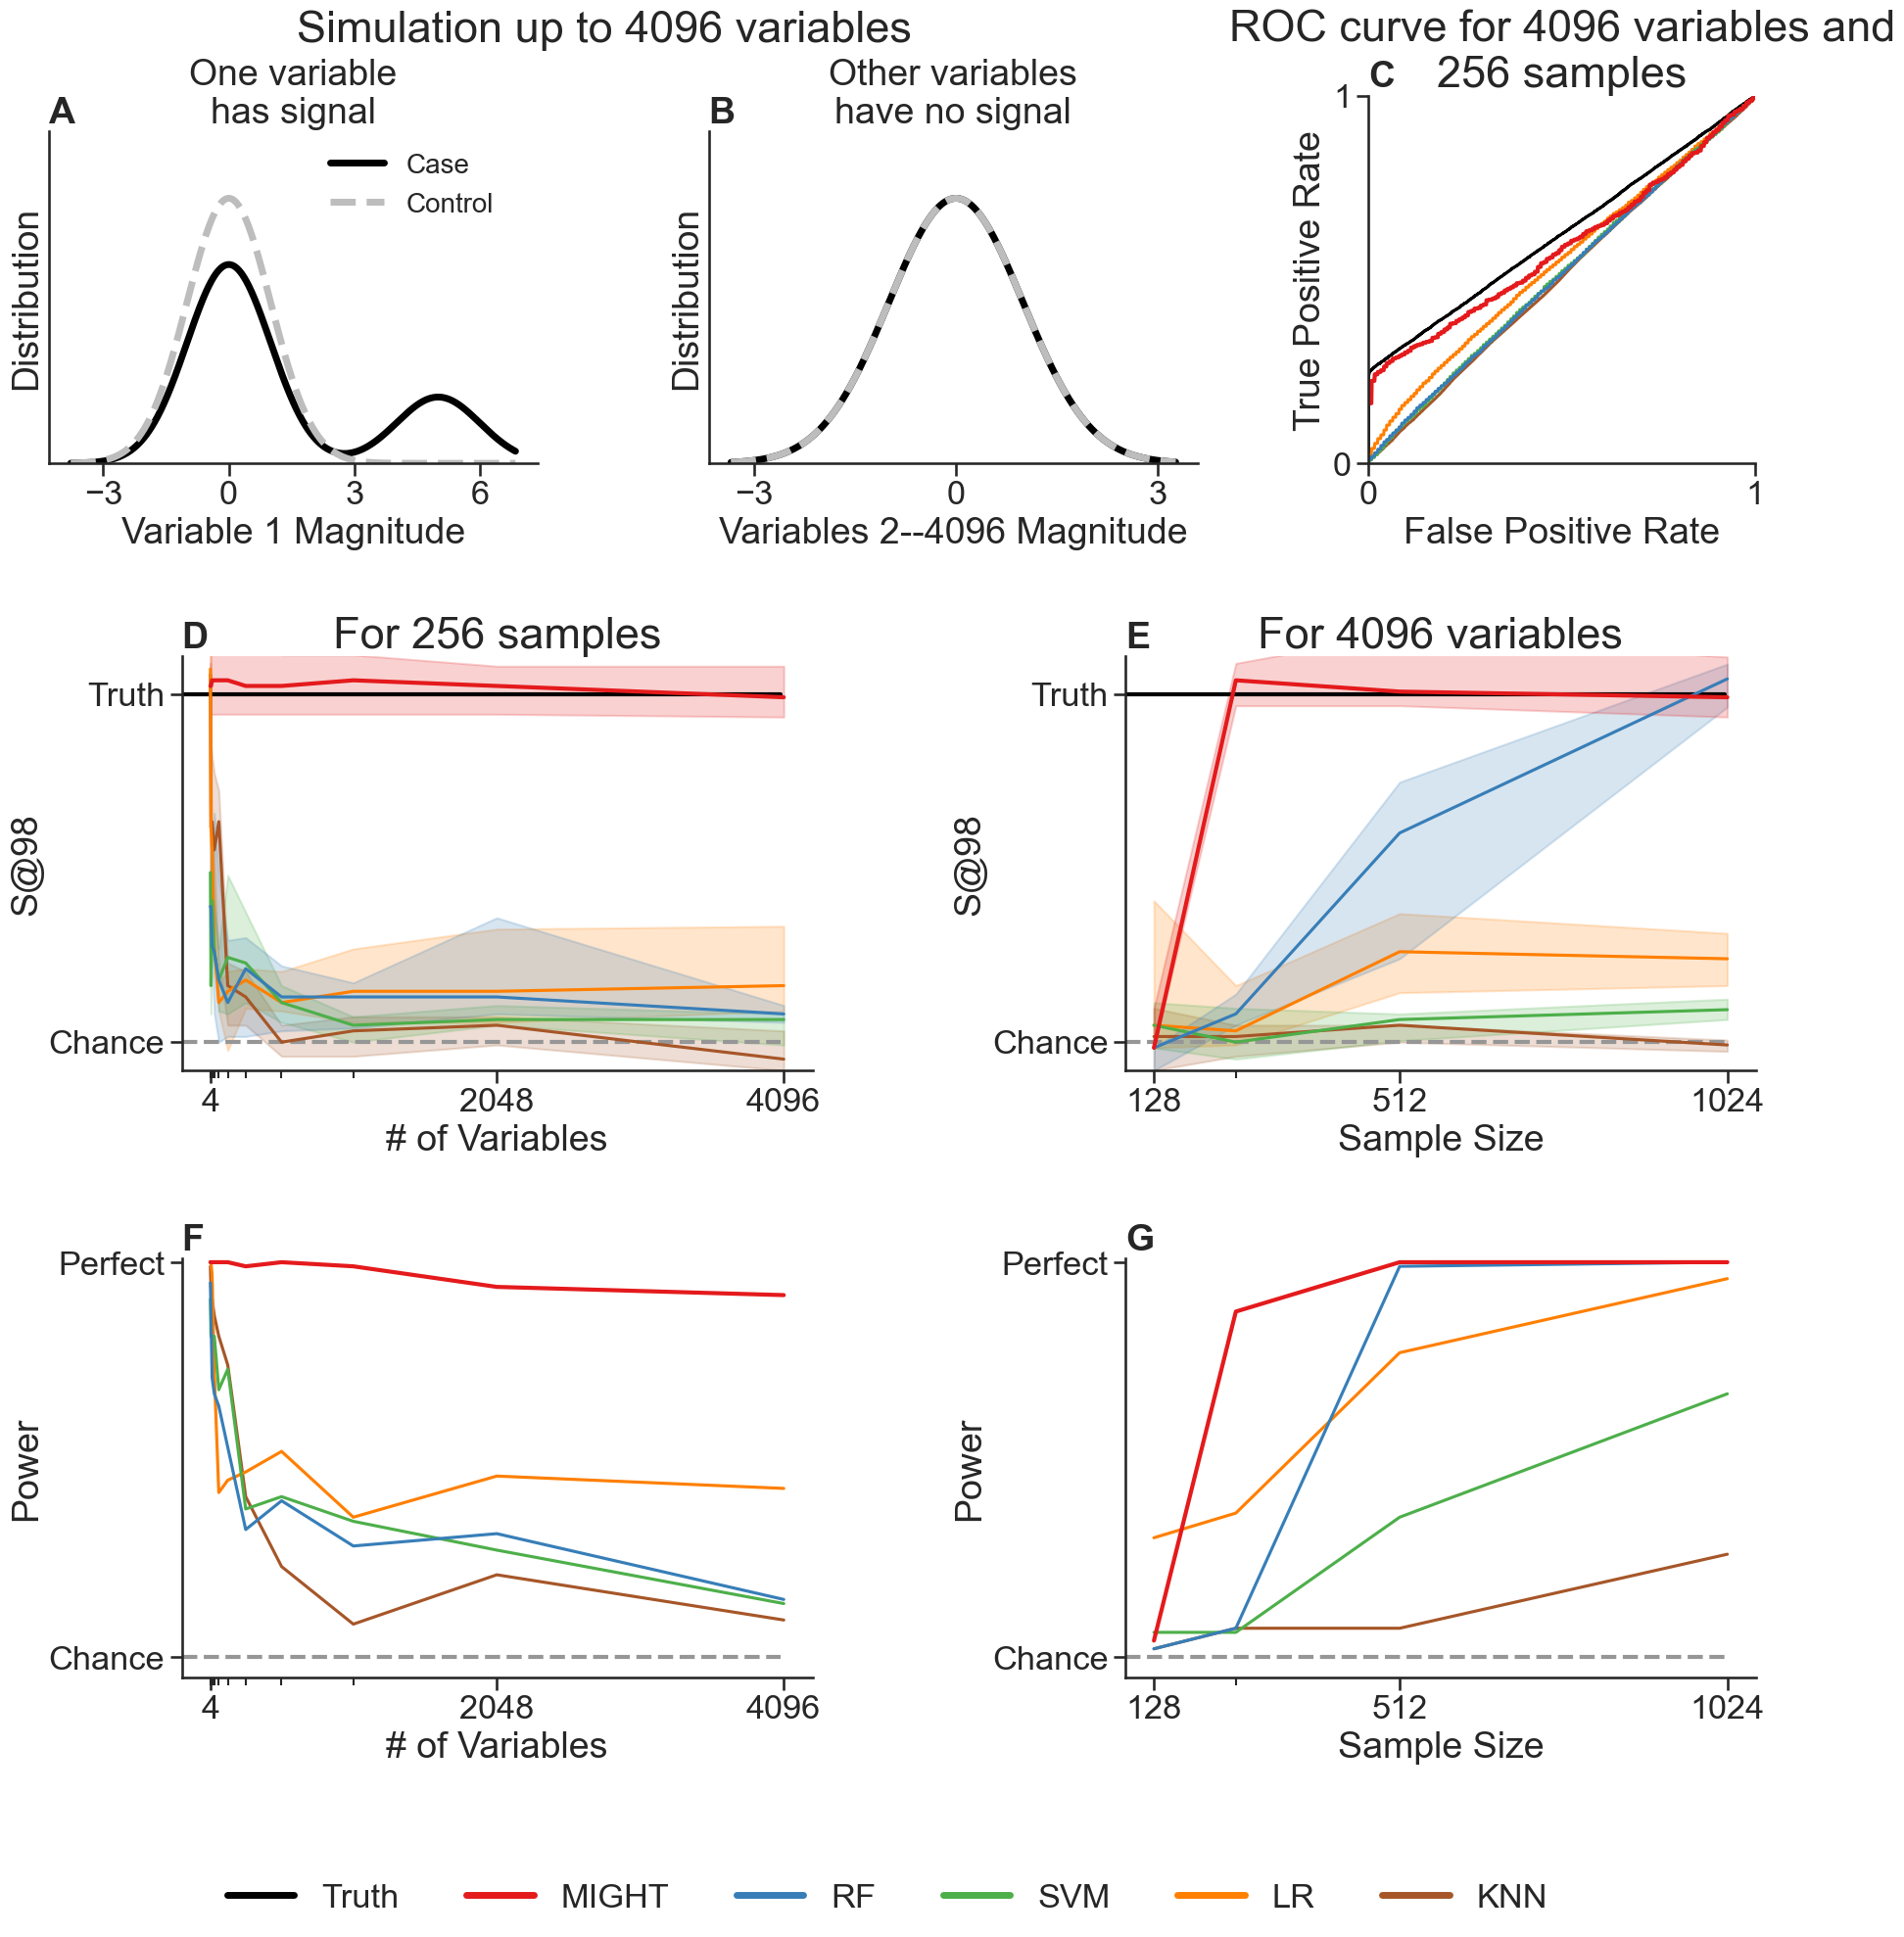

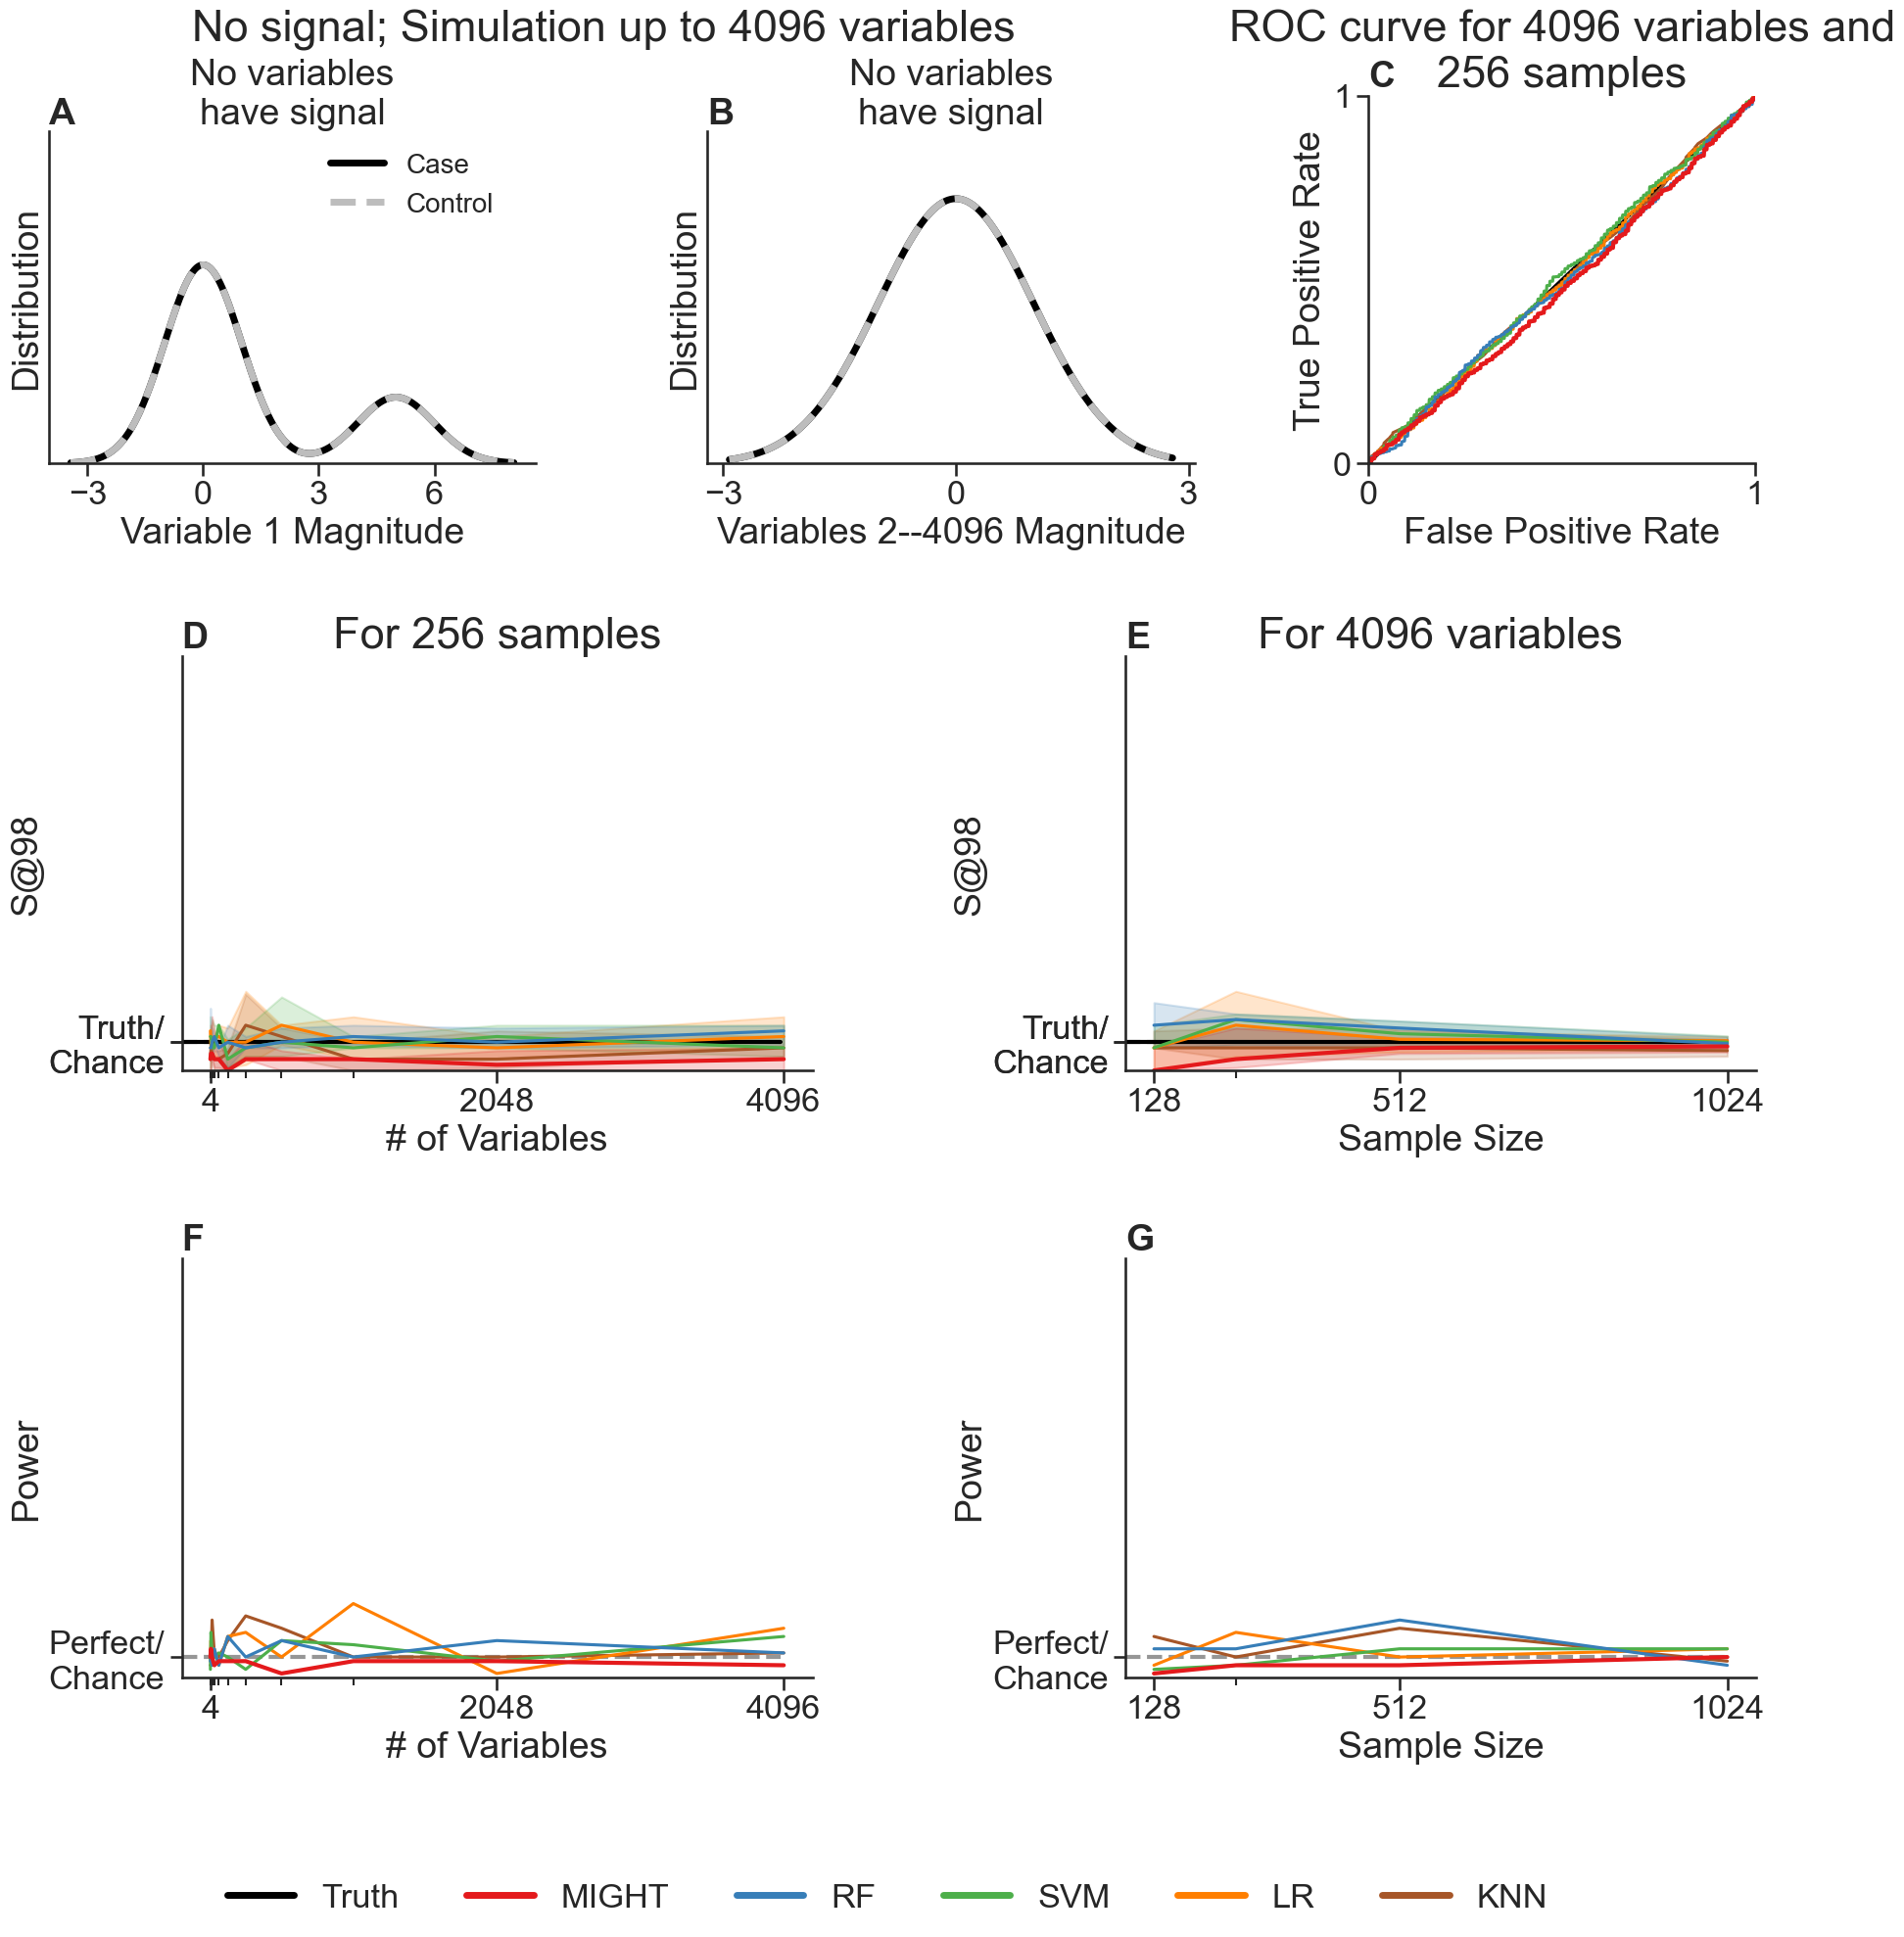

In [40]:
ROW_ORDER = [
    "S@98",
    # "AUC",
    # "Mutual Information",
    "Power"
]

class PlotFigures(ABC):
    def __init__(self, simulation_name, simulation_kwargs=None, roc_iterations=100, truths=None, simulation_ticks=[-3, 0, 3]):
        self.simulation_name = simulation_name
        self.simulation_kwargs = simulation_kwargs
        self.roc_iterations = roc_iterations
        self.truths = truths
        self.simulation_ticks = simulation_ticks
        self.chance = {
            "S@98" : 0.02,
            "AUC": 0.5,
            "Mutual Information": 0,
            "Power" : 0.05,
        }

    def plot_figure(self):
        # define figure attributes
        fig = plt.figure(figsize=(18, 18), constrained_layout=True)
        self.ncols = 3
        subfigs = fig.subfigures(3, 1, hspace=0.1)
        subfigs_top = subfigs[0].subfigures(1, 2, width_ratios=[2.5, 1], wspace=0.1)
        axs_sims = subfigs_top[0].subplots(1, 2)
        axs_roc = subfigs_top[1].subplots(1, 1)
        axs_inc_n = subfigs[1].subplots(1, 2)
        axs_inc_d = subfigs[2].subplots(1, 2)
        subfigs_top[0].get_layout_engine().set(wspace=0)
        subfigs[1].get_layout_engine().set(wspace=0.15)
        subfigs[2].get_layout_engine().set(wspace=0.15)
        self.axes = [*axs_sims, axs_roc, *axs_inc_n, *axs_inc_d]
        
        self.plot_simulations()
        self.plot_roc()
        self.plot_metrics_power()

        # misc section titles
        subfigs_top[0].suptitle(f"{'No signal; ' if self.simulation_name == 'independent' else ''}Simulation up to 4096 variables")
        axs_roc.set_title("ROC curve for 4096 variables and\n256 samples", fontsize='large')
        self.axes[4].set_title("For 4096 variables", fontsize='large')
        self.axes[3].set_title("For 256 samples", fontsize='large')

        # add lettering
        for i, ax in enumerate(self.axes):
            ax.set_title(
                string.ascii_uppercase[i], loc="left", weight="bold"
            )
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)

        # add legends
        leg_sims = fig.legend(
            *self.axes[1].get_legend_handles_labels(),
            loc="upper left",
            ncol=1,
            bbox_to_anchor=(0.17, 0.93),
            fontsize=20,
        )
        leg_roc = fig.legend(
            handles=[self.axes[2].get_legend_handles_labels()[0][0]] + self.axes[2].get_legend_handles_labels()[0][1:][::-1],
            labels=[self.axes[2].get_legend_handles_labels()[1][0]] + self.axes[2].get_legend_handles_labels()[1][1:][::-1],
            # *self.axes[2].get_legend_handles_labels(),
            loc="lower center",
            ncol=len(self.axes[2].get_legend_handles_labels()[1]) + 1,
            bbox_to_anchor=(0.5, -0.1),
            # columnspacing=4.0
        )
        # leg_mi = fig.legend(
        #     handles=[self.axes[6].get_legend_handles_labels()[0][-1]],
        #     labels=[self.axes[6].get_legend_handles_labels()[1][-1]],
        #     loc="lower center",
        #     ncol=1,
        #     bbox_to_anchor=(0.741, -0.13)
        # )
        # leg_power = fig.legend(
        #     handles=[self.axes[5].get_legend_handles_labels()[0][-1]],
        #     labels=[self.axes[5].get_legend_handles_labels()[1][-1]],
        #     loc="lower center",
        #     ncol=1,
        #     bbox_to_anchor=(0.873, -0.16)
        # )
        # for leg in [leg_sims, leg_roc, leg_mi, leg_power]:
        for leg in [leg_sims, leg_roc]:
            leg.get_frame().set_linewidth(0)
            for legobj in leg.legend_handles:
                legobj.set_linewidth(5.0)

        plt.savefig(f"figs/might_{self.simulation_name}_main.pdf", transparent=True, bbox_inches='tight')
        plt.show()

    def plot_simulations(self, n=50):
        pdf = self._generate_data(n, **self.simulation_kwargs)[-1]
        pdf_noise = self._generate_data(n, mu_class1=0)[-1]

        for i, plot_pdf in enumerate([pdf, pdf_noise]):
            sns.lineplot(
                plot_pdf,
                x="x",
                y="pdf_class1",
                color="black",
                ax=self.axes[i],
                label="Case",
                linestyle='solid',
                legend=False,
                lw=5
            )
            sns.lineplot(
                plot_pdf,
                x="x",
                y="pdf_class0",
                color="#bdbdbd",
                ax=self.axes[i],
                label="Control",
                linestyle="--",
                legend=False,
                lw=5
            )

        # make plot look pretty
        self.axes[0].set(
            xlabel="Variable 1 Magnitude",
            ylabel="Distribution",
            xticks=self.simulation_ticks,
            yticks=[],
            ylim=[0, 0.5],
            title="One variable\nhas signal" if self.simulation_name == "nonlinear" else "No variables\nhave signal"
        )
        self.axes[1].set(
            xlabel="Variables 2--4096 Magnitude",
            ylabel="Distribution",
            xticks=[-3, 0, 3],
            yticks=[],
            ylim=[0, 0.5],
            title="Other variables\nhave no signal" if self.simulation_name == "nonlinear" else "No variables\nhave signal"
        )

        # simulated_df = pd.DataFrame(dict(x=x.ravel(), x_noise=x_noise.ravel(), hue=np.tile([0, 1], n // 2)))
        # sns.scatterplot(simulated_df, x="x", y="x_noise", hue="hue", ax=self.axes[2], palette=["black", "#969696"], legend=False)

        # # make plot look pretty
        # self.axes[2].set(
        #     xlabel="Variable 1",
        #     ylabel="Other Variables",
        #     xticks=self.simulation_ticks,
        #     yticks=[-3, 0, 3]
        # )

    @staticmethod
    def _generate_data(n=256, **kwargs):
        return generate_gauss_mix(
            N=n,
            **kwargs,
        )

    def plot_roc(self):
        # compute true fpr, tpr, and thresholds and plot the ROC
        x, y, posterior, *_ = self._generate_data(n=50000, **self.simulation_kwargs)
        true_fpr, true_tpr, true_thresholds = roc_curve(
            y, posterior, pos_label=1, drop_intermediate=False
        )
        # self.axes[2].plot([0, 1], [0, 1], linestyle="--", color="black", alpha=0.5),
        self.axes[2].plot(true_fpr, true_tpr, color="black", label="Truth")
        
        # load all other classifier ROC data and plot ROC curves
        base_fpr = np.linspace(0, 1, 1001)
        for clf_name, plot_kwargs in COMMON_CLFS.items():
            try:
                with open(f"fig1_v2_results/fpr_{self.simulation_name}_{clf_name}.pkl", "rb") as f:
                    clf_fpr = pickle.load(f)
            except FileNotFoundError:
                print(f"fig1_v2_results/fpr_{self.simulation_name}_{clf_name}.pkl is missing")
                continue
            try:
                with open(f"fig1_v2_results/tpr_{self.simulation_name}_{clf_name}.pkl", "rb") as f:
                    clf_tpr = pickle.load(f)
            except FileNotFoundError:
                print(f"fig1_v2_results/tpr_{simulation_name}_{clf_name}.pkl is missing")
                continue
            clf_tprs = []
            for i in range(self.roc_iterations):
                try:
                    clf_tprs.append(np.interp(base_fpr, clf_fpr[i], clf_tpr[i]))
                except IndexError:
                    break
            mean_clf_tpr = np.mean(clf_tprs, axis=0)
            self.axes[2].plot(base_fpr, mean_clf_tpr, **plot_kwargs, label=clf_name)

        # make plot look pretty
        self.axes[2].set(
            xlabel="False Positive Rate",
            ylabel="True Positive Rate",
            xticks=[0, 1],
            yticks=[0, 1],
            xlim=[0, 1],
            ylim=[0, 1]
        )

    def plot_metrics_power(self):
        for i, ax in enumerate(self.axes[self.ncols:]):
            metric = ROW_ORDER[i // 2]

            if i % 2 == 1:
                xs = [128, 256, 512, 1024]#, 2048, 4096]
                n_or_d = "n"
            else:
                xs = [2**i for i in range(2, 13)]
                n_or_d = "d"

            ax.axhline(
                y=self.chance[metric],
                color="#969696",
                lw=3,
                xmax=0.95,
                linestyle="dashed",
                label="Truth"
            )

            if metric != "Power":
            #     ax.axhline(
            #         y=0.05,
            #         linestyle=":",
            #         color="black",
            #         label="Alpha",
            #     )
            # else:
                ax.axhline(
                    y=self.truths[metric],
                    color="black",
                    lw=3,
                    xmax=0.95,
                )

            for test, plot_kwargs in ALL_CLFS[metric].items():
                file_test = test if test != "MIGHT" else test.lower()
                if metric == "Power" and test == "MIGHT":
                    file_test += "-S98"
                try:
                    ys = np.genfromtxt(
                        f"results_100k/{self.simulation_name}-{file_test}-{FILE_METRICS[metric]}-vs-{n_or_d}.csv", delimiter=","
                    )
                except FileNotFoundError:
                    print(f"results_100k/{self.simulation_name}-{file_test}-{FILE_METRICS[metric]}-vs-{n_or_d}.csv is missing")
                    continue
                if metric == "Power":
                    ys = np.array([y if y > 0 else 0 for y in ys])
                    if n_or_d == "n" and test in ["MIGHT", "Dcorr", "Dcorr_PCA"]:
                        ys = ys[1:-2]
                    elif n_or_d == "n":
                        ys = ys[:-2]
                    if test == "Dcorr_PCA":
                        test = "Dcorr-PCA"
                    ax.plot(xs, ys, **plot_kwargs, label=test)
                else:
                    quantiles = []
                    for quantile in [0.25, 0.5, 0.75]:
                        if test not in ["MIGHT", "RF"]:
                            ys = ys[:, :10]
                        quartile = np.quantile(ys, quantile, axis=1)
                        quartile = np.array([y if y > 0 else 0 for y in quartile])
                        quartile = quartile[:-2] if n_or_d == "n" else quartile
                        if test in ["MIGHT", "RF"] and n_or_d == "n":
                            quartile = quartile[1:]
                        quantiles.append(quartile)
                    # ax.plot(xs, quantiles[2] - quantiles[0], **plot_kwargs, label=test)
                    ax.plot(xs, quantiles[1], **plot_kwargs, label=test)
                    ax.fill_between(
                        xs,
                        quantiles[0],
                        quantiles[2],
                        alpha=0.2,
                        color=plot_kwargs["color"],
                    )
                    # data = pd.DataFrame(dict(x=np.tile(xs, 10) if test in ["MIGHT", "RF"] else np.tile(xs, 10), y=ys[1:-2].ravel(order="F") if test in ["MIGHT", "RF"] and n_or_d == "n" else ys[:-2].ravel(order="F") if test in ["MIGHT", "RF"] else  ys[:-2].ravel(order="F")[:10] if n_or_d == "n" else  ys.ravel(order="F")[:10]))
                    # sns.lineplot(data=data, x="x", y="y", errorbar=("ci", 95), **plot_kwargs, label=test, ax=ax, legend=False)

            # make plot pretty
            ax.set(
                # xscale="log" if metric == "Power" and n_or_d == "n" else "linear",
                xlabel = (
                    "Sample Size" if n_or_d == "n"
                    else "# of Variables"
                ),
                ylim=(
                    [0, 0.286] if metric == "S@98"
                    else [0.5, 0.64] if metric == "AUC"
                    else [0, 1.01]
                    # else [0.5, (self.truths[metric] - 0.5) / 0.13 * 0.01 + self.truths[metric]] if metric == "AUC"
                    # else [0, 1.1 * self.truths[metric]]
                ),
                yticks=(
                    # [0, 1] if metric == "Power"
                    # else [0, 0.5, 1] if self.simulation_name == "independent" and metric == "AUC"
                    # else [0, self.truths[metric], 0.1] if self.simulation_name == "independent"
                    # else [0.5, self.truths[metric]] if metric == "AUC"
                    # else [0, self.truths[metric]]
                    [0.05] if metric == "Power" and self.simulation_name == "independent"
                    else [0.05, 1] if metric == "Power"
                    else [self.chance[metric], self.truths[metric]]
                ),
                yticklabels=(
                    ["Perfect/\nChance"] if self.simulation_name == "independent" and metric == "Power"
                    else ["", "Truth/\nChance"] if self.simulation_name == "independent"
                    else ["Chance", "Perfect"] if metric == "Power"
                    else ["Chance", "Truth"]
                ),
                ylabel=(
                    f"{metric}"
                )
            )
            ax.xaxis.set_minor_locator(FixedLocator(xs))
            ax.xaxis.set_major_locator(FixedLocator(
                [128, 512, 1024] if n_or_d == "n"
                else [4, 2048, 4096]
            ))
            # ax.xaxis.set_major_formatter(ScalarFormatter())
            # ax.xaxis.set_minor_formatter(NullFormatter())

class PlotNonlinearFigure(PlotFigures):
    def __init__(self):
        super().__init__(
            simulation_name="nonlinear",
            simulation_kwargs=dict(split_class1=(0.75, 0.25)),
            truths={
                "S@98" : 0.26,
                "AUC": 0.63,
                "Mutual Information": 0.09,
            },
            simulation_ticks=[-3, 0, 3, 6]
        )

    def __call__(self):
        self.plot_figure()

nonlinear_figure = PlotNonlinearFigure()
nonlinear_figure()

class PlotIndependentFigure(PlotFigures):
    def __init__(self):
        super().__init__(
            simulation_name="independent",
            simulation_kwargs=dict(split_class0=(0.75, 0.25), split_class1=(0.75, 0.25)),
            truths={
                "S@98" : 0.02,
                "AUC": 0.5,
                "Mutual Information": 0,
            },
            simulation_ticks=[-3, 0, 3, 6]
        )

    def __call__(self):
        self.plot_figure()

independent_figure = PlotIndependentFigure()
independent_figure()

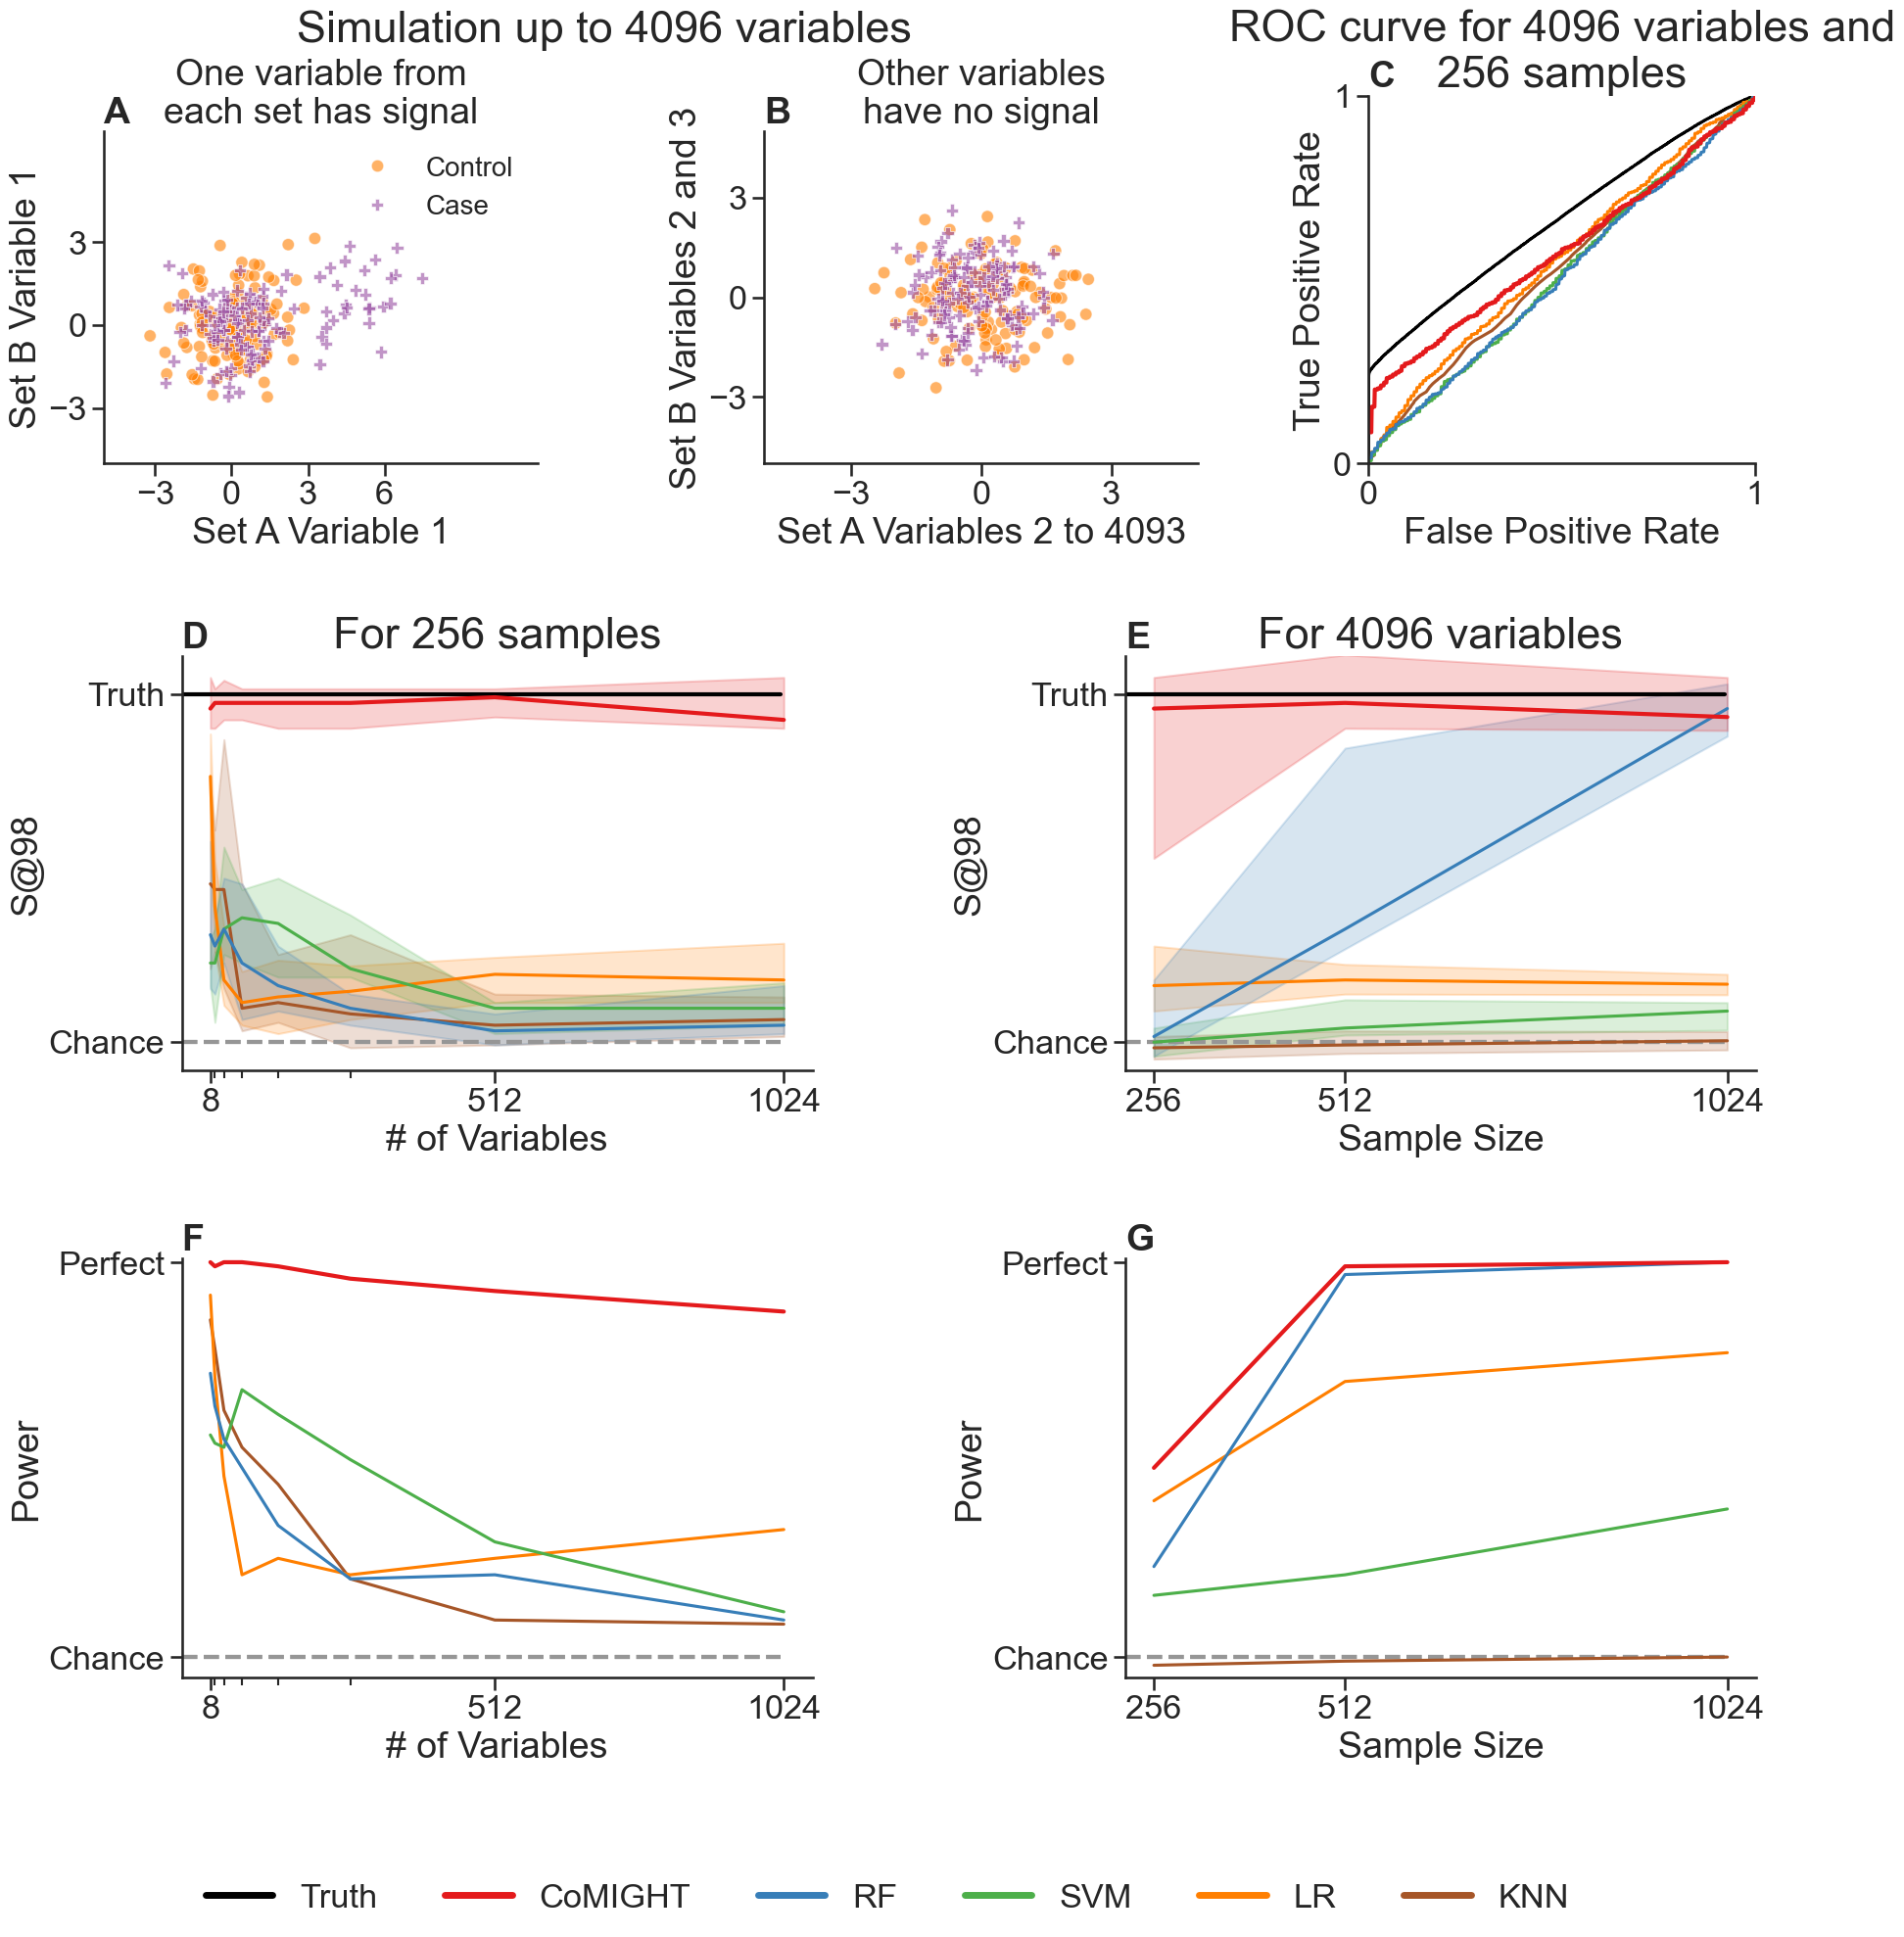

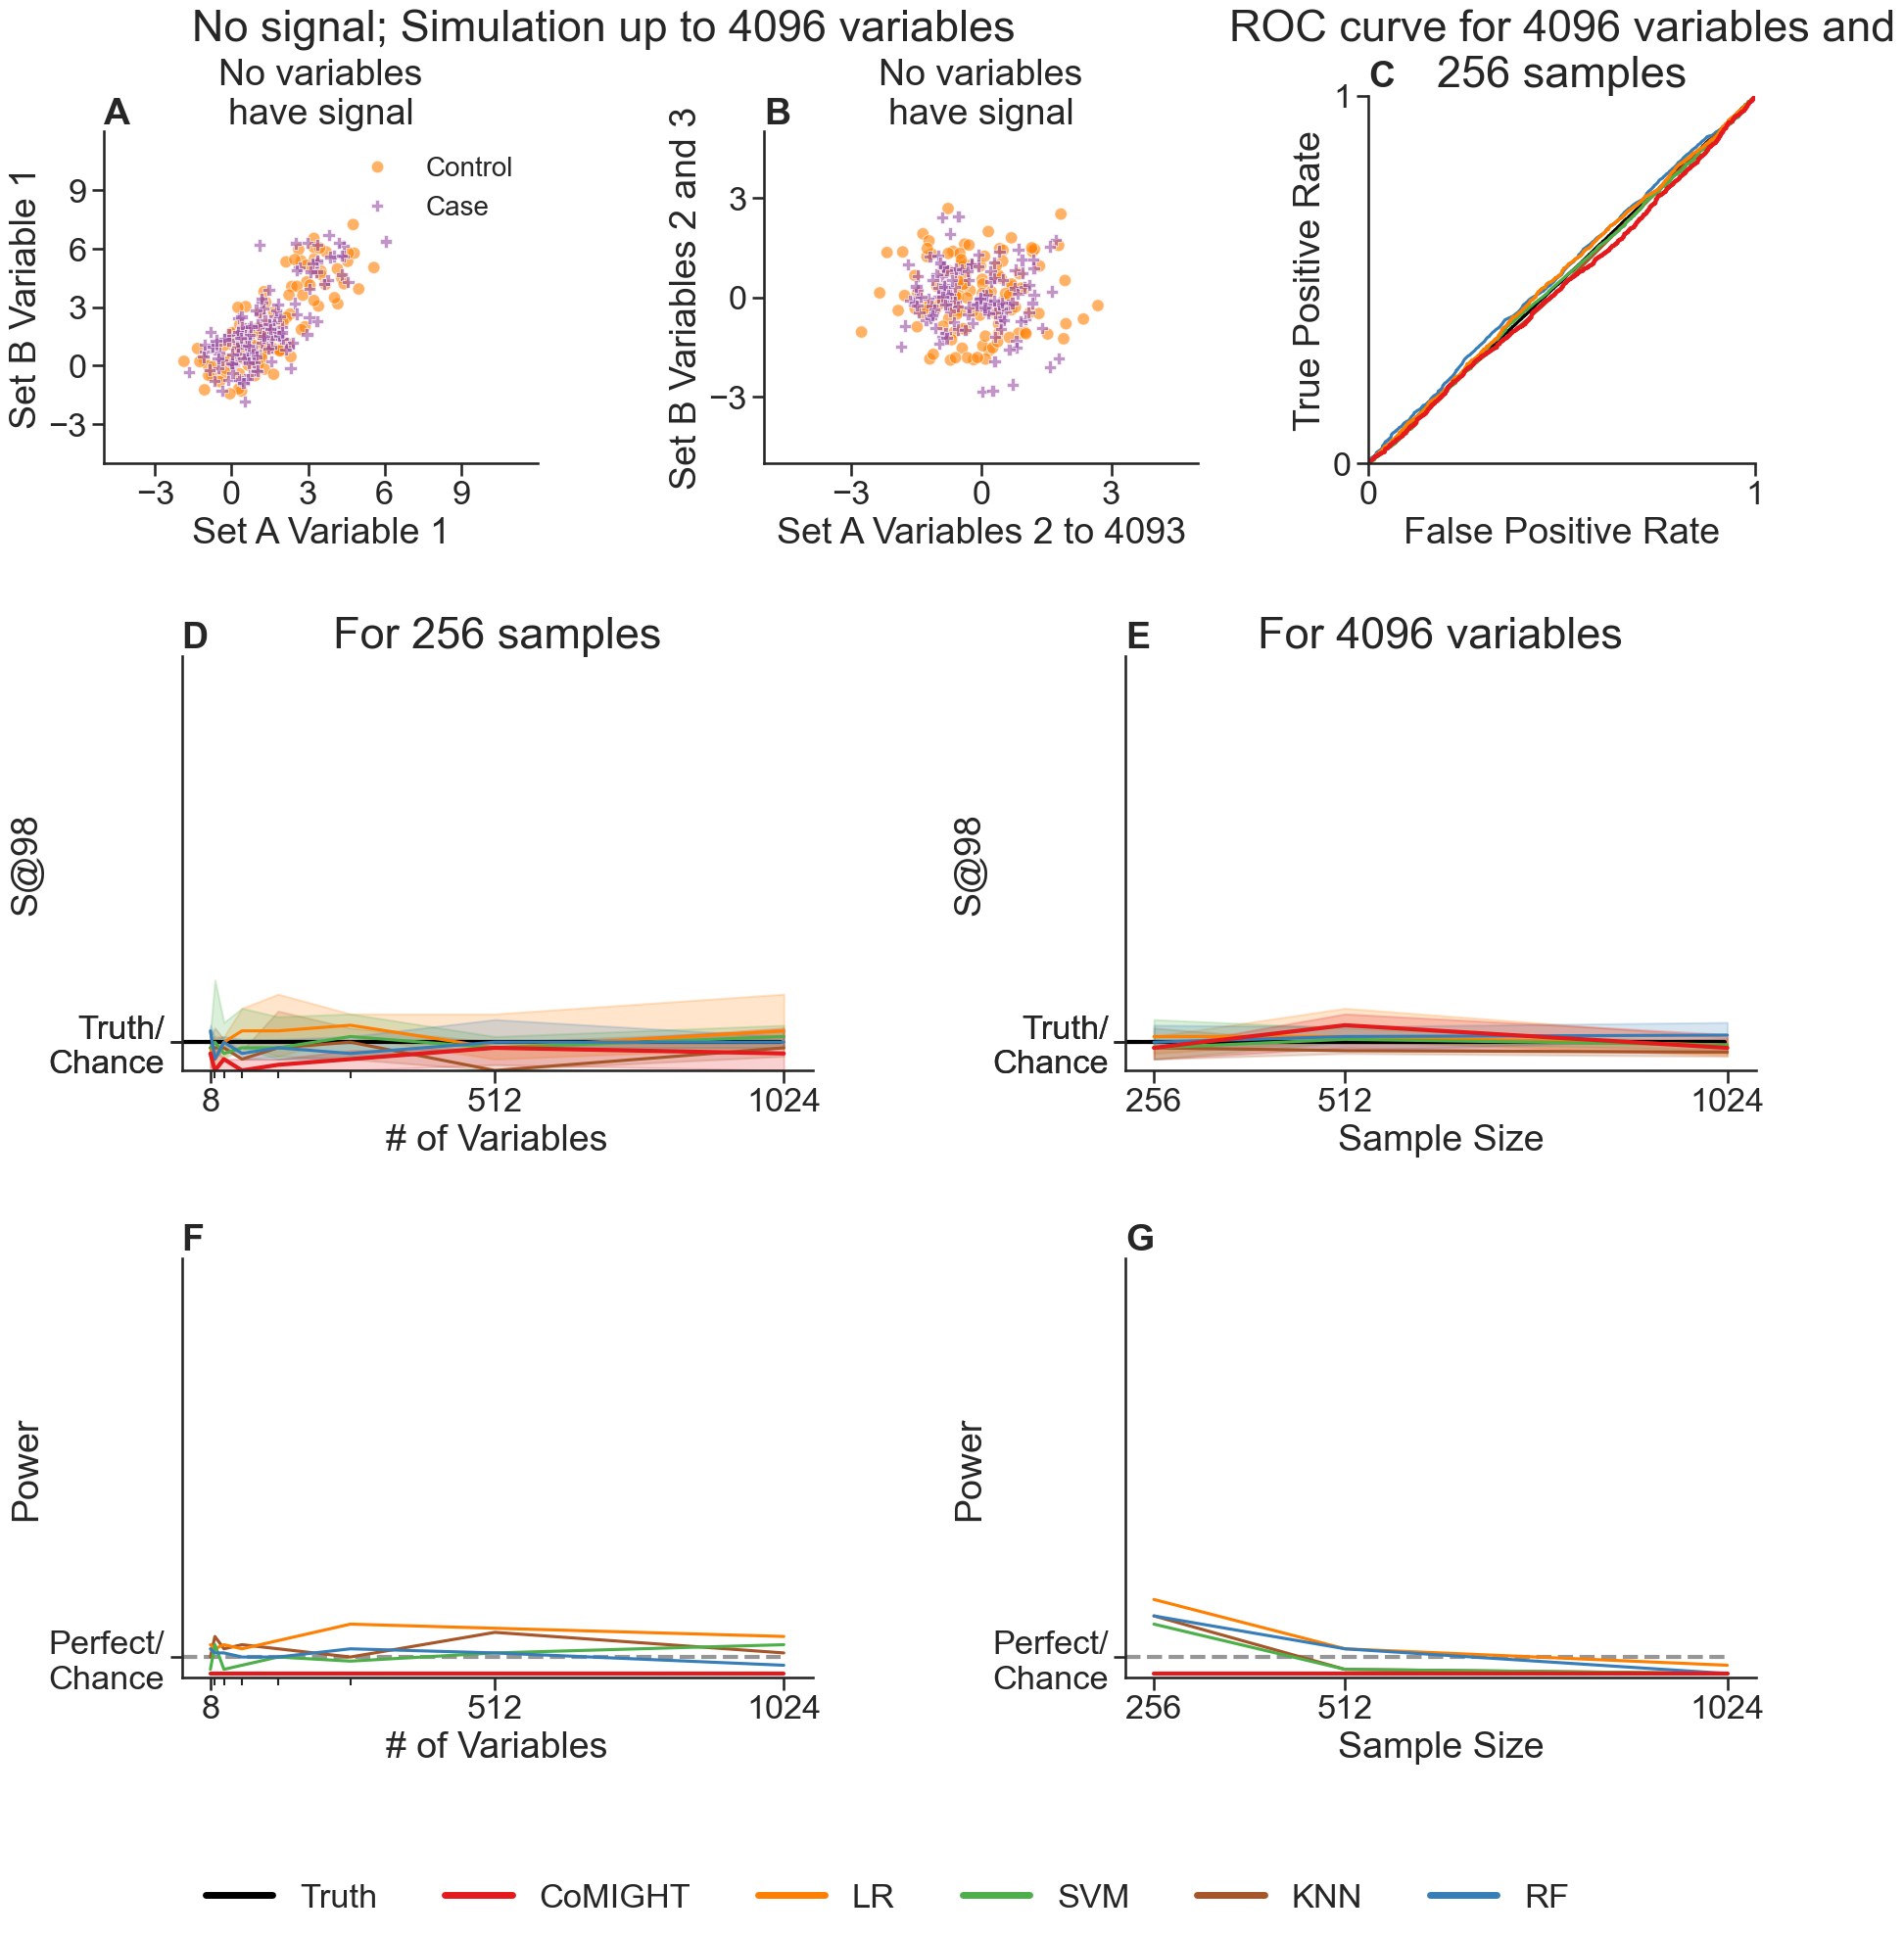

In [56]:
CONDITIONAL_ROW_ORDER = [
    "S@98",
    # "AUC",
    # "Mutual Information",
    "Power"
]

class PlotConditionalFigures(ABC):
    def __init__(self, simulation_name, simulation_kwargs=None, roc_iterations=100, truths=None, simulation_ticks=[-3, 0, 3]):
        self.simulation_name = simulation_name
        self.simulation_kwargs = simulation_kwargs
        self.roc_iterations = roc_iterations
        self.truths = truths
        self.simulation_ticks = simulation_ticks
        self.chance = {
            "S@98" : 0.02,
            # "AUC": 0.5,
            # "Mutual Information": 0,
            "Power" : 0.05,
        }

    def plot_figure(self):
        # define figure attributes
        fig = plt.figure(figsize=(18, 18), constrained_layout=True)
        self.ncols = 3
        subfigs = fig.subfigures(3, 1, hspace=0.1)
        subfigs_top = subfigs[0].subfigures(1, 2, width_ratios=[2.5, 1], wspace=0.1)
        axs_sims = subfigs_top[0].subplots(1, 2)
        axs_roc = subfigs_top[1].subplots(1, 1)
        axs_inc_n = subfigs[1].subplots(1, 2)
        axs_inc_d = subfigs[2].subplots(1, 2)
        subfigs_top[0].get_layout_engine().set(wspace=0)
        subfigs[1].get_layout_engine().set(wspace=0.15)
        subfigs[2].get_layout_engine().set(wspace=0.15)
        self.axes = [*axs_sims, axs_roc, *axs_inc_n, *axs_inc_d]
        
        self.plot_simulations()
        self.plot_roc()
        self.plot_metrics_power()

        # misc section titles
        subfigs_top[0].suptitle(f"{'No signal; ' if self.simulation_name == 'independent' else ''}Simulation up to 4096 variables")
        self.axes[0].set_title("{}".format("One variable from\neach set has signal" if self.simulation_name == "nonlinear" else "No variables\nhave signal"))
        self.axes[1].set_title("{}".format("Other variables\nhave no signal" if self.simulation_name == "nonlinear" else "No variables\nhave signal"))
        axs_roc.set_title("ROC curve for 4096 variables and\n256 samples", fontsize='large')
        self.axes[4].set_title("For 4096 variables", fontsize='large')
        self.axes[3].set_title("For 256 samples", fontsize='large')

        # add lettering
        for i, ax in enumerate(self.axes):
            ax.set_title(
                string.ascii_uppercase[i], loc="left", weight="bold"
            )
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)

        # add legends
        # leg_sims = fig.legend(
        #     *self.axes[1].get_legend_handles_labels(),
        #     loc="upper left",
        #     ncol=1,
        #     bbox_to_anchor=(0.17, 0.95),
        #     fontsize=20,
        #     labels=["Case", "Control"]
        # )
        leg_roc = fig.legend(
            handles=[self.axes[2].get_legend_handles_labels()[0][0]] + self.axes[2].get_legend_handles_labels()[0][1:][::-1],
            labels=[self.axes[2].get_legend_handles_labels()[1][0]] + self.axes[2].get_legend_handles_labels()[1][1:][::-1],
            loc="lower center",
            ncol=len(self.axes[2].get_legend_handles_labels()[1]) + 1,
            bbox_to_anchor=(0.5, -0.1),
            # columnspacing=4.0
        )
        # leg_mi = fig.legend(
        #     handles=[self.axes[6].get_legend_handles_labels()[0][-1]],
        #     labels=[self.axes[6].get_legend_handles_labels()[1][-1]],
        #     loc="lower center",
        #     ncol=1,
        #     bbox_to_anchor=(0.741, -0.13)
        # )
        # leg_power = fig.legend(
        #     handles=[self.axes[5].get_legend_handles_labels()[0][-1]],
        #     labels=[self.axes[5].get_legend_handles_labels()[1][-1]],
        #     loc="lower center",
        #     ncol=1,
        #     bbox_to_anchor=(0.873, -0.16)
        # )
        # for leg in [leg_sims, leg_roc, leg_mi, leg_power]:
        for leg in [leg_roc]:
            leg.get_frame().set_linewidth(0)
            for legobj in leg.legend_handles:
                legobj.set_linewidth(5.0)

        plt.savefig(f"figs/comight_{self.simulation_name}_appendix.pdf", transparent=True, bbox_inches='tight')
        plt.show()

    def plot_simulations(self, n=512):
        # pdf = self._generate_data(n, **self.simulation_kwargs)[-1]
        # pdf_noise = self._generate_data(n, mu_class1=0)[-1]

        # for i, plot_pdf in enumerate([pdf, pdf_noise]):
        #     sns.lineplot(
        #         plot_pdf,
        #         x="x",
        #         y="pdf_class1",
        #         color="#bdbdbd",
        #         ax=self.axes[i],
        #         label="Case",
        #         linestyle='solid',
        #         legend=False,
        #         lw=5
        #     )
        #     sns.lineplot(
        #         plot_pdf,
        #         x="x",
        #         y="pdf_class0",
        #         color="black",
        #         ax=self.axes[i],
        #         label="Control",
        #         linestyle=(0, (5, 5)),
        #         legend=False,
        #         lw=5
        #     )

        # # make plot look pretty
        # self.axes[0].set(
        #     xlabel="Variable 1 in Sets A/B",
        #     ylabel="Distribution",
        #     xticks=self.simulation_ticks,
        #     yticks=[],
        #     ylim=[0, 0.5]
        # )
        # self.axes[1].set(
        #     xlabel="Other variables in Sets A/B",
        #     ylabel="",
        #     xticks=[-3, 0, 3],
        #     yticks=[],
        #     ylim=[0, 0.5]
        # )

        if self.simulation_name == "nonlinear":
            v1, v2, y = self.make_multi_modal()
        else:
            v1, v2, y = self.make_multi_equal()
        simulated_df = pd.DataFrame(dict(
            s1v1=v1[:, 0],
            s2v1=v2[:, 0],
            s1v2=v1[:, 1],
            s2v2=v2[:, 1],
            hue=y.ravel(),
        ))
        scatter = sns.scatterplot(
            simulated_df,
            x="s1v1",
            y="s2v1",
            hue="hue",
            ax=self.axes[0],
            palette=["#ff7f00", "#984ea3"],
            style="hue",
            markers=['o', 'P'],
            alpha=0.6,
            legend=True,
        )
        scatter.legend(
            title=False,
            frameon=False,
            loc="upper right",
            ncol=1,
            # bbox_to_anchor=(0.17, 0.95),
            fontsize=20,
            handles=self.axes[0].get_legend_handles_labels()[0],
            labels=["Control", "Case"],
            # markerscale=2
        )
        sns.scatterplot(
            simulated_df,
            x="s1v2",
            y="s2v2",
            hue="hue",
            ax=self.axes[1],
            palette=["#ff7f00", "#984ea3"],
            style="hue",
            markers=['o', 'P'],
            alpha=0.6,
            legend=False
        )

        # # make plot look pretty
        self.axes[0].set(
            xlabel="Set A Variable 1",
            ylabel="Set B Variable 1",
            xticks=self.simulation_ticks if self.simulation_name == "nonlinear" else [-3, 0, 3, 6, 9],
            yticks=[-3, 0, 3] if self.simulation_name == "nonlinear" else [-3, 0, 3, 6, 9],
            xlim=[-5, 12],
            ylim=[-5, 7] if self.simulation_name == "nonlinear" else [-5, 12],
        )
        self.axes[1].set(
            xlabel="Set A Variables 2 to 4093",
            ylabel="Set B Variables 2 and 3",
            xticks=self.simulation_ticks,
            yticks=[-3, 0, 3],
            xlim=[-5, 5],
            ylim=[-5, 5]
        )

    @staticmethod
    def make_multi_modal(
        n_samples=256,
        n_dim_1=2,
        mu_viewone=5,
        mu_viewtwo=1,
        mix=0.75,
        rho=0.2,
        seed=None,
        n_dim_2=2,
    ):
        """Make multi-modal binary classification data."""
        rng = np.random.default_rng(seed)
    
        method = "svd"
        mu_1_vec = np.array([mu_viewone, mu_viewtwo])
        mu_0_vec = np.array([0, 0])
        cov = np.array([[1.5, rho], [rho, 1.5]])
    
        mixture_idx = rng.choice(2, n_samples // 2, replace=True, shuffle=True, p=[mix, 1 - mix])  # type: ignore
        norm_params = [[mu_0_vec, np.eye(2)], [mu_1_vec, cov]]
        X_mixture = np.fromiter(
            (
                rng.multivariate_normal(*(norm_params[i]), size=1, method=method)
                for i in mixture_idx
            ),
            dtype=np.dtype((float, 2)),
        )
    
        X = np.vstack(
            (
                rng.multivariate_normal(np.zeros(2), cov, n_samples // 2, method=method),
                X_mixture.reshape(n_samples // 2, 2),
            )
        )
    
        assert X.shape[1] == 2
        view_1 = X[:, (0,)]
        view_1 = np.hstack(
            (view_1, rng.normal(loc=0, scale=1, size=(X.shape[0], n_dim_1 - 1)))
        )
        view_2 = X[:, 1:]
        # add noise to the second view so that view_2 = (n_samples, n_dim_2)
        view_2 = np.concatenate(
            (view_2, rng.standard_normal(size=(n_samples, n_dim_2 - view_2.shape[1]))),
            axis=1,
        )
    
        X = np.concatenate((view_1, view_2), axis=1)
        y = np.concatenate((np.zeros(n_samples // 2), np.ones(n_samples // 2)))
        return view_1, view_2, y

    @staticmethod
    def make_multi_equal(
        n_samples=256,
        n_dim_1=2,
        mu_0=1,
        mu_1=5,
        mix=0.75,
        seed=None,
        n_dim_2=2,
    ):
        """Make multi-modal binary classification data.
    
        X comprises of [view_1, view_2] where view_1 is the first ``n_dim_1`` dimensions
        and view_2 is the last ``n_dim_2`` dimensions.
    
        view_1 is generated, such that [A, B] corresponding to class labels [0, 1]
        are generated as follows:
    
        A ~ mix * N(1, I) + (1 - mix) * N(m_factor, I)
        B ~ mix * N(1, I) + (1 - mix) * N(m_factor, I)
    
        view_2 is generated, such that [A, B] corresponding to class labels [0, 1]
        are generated as follows:
    
        A ~ mix * N(1 / np.sqrt(2), I) + (1 - mix) * N(1 / np.sqrt(2) * m_factor, I)
        B ~ mix * N(1 / np.sqrt(2), I) + (1 - mix) * N(1 / np.sqrt(2) * m_factor, I)
    
        Parameters
        ----------
        n_samples : int, optional
            The number of samples to generate, by default 1024.
        n_dim_1 : int, optional
            The number of dimensions in first view, by default 4090.
        mu_0 : int, optional
            The mean of the first class, by default 1.
        mu_1 : int, optional
            The mean of the second class, by default -1.
        seed : int, optional
            Random seed, by default None.
        n_dim_2 : int, optional
            The number of dimensions in second view, by default 6.
        return_params : bool
            Whether to return parameters of the generating model or not. Default is False.
    
        Returns
        -------
        X : ArrayLike of shape (n_samples, n_dim_1 + n_dim_2)
            Data.
        y : ArrayLike of shape (n_samples,)
            Labels.
        """
        rng = np.random.default_rng(seed)
        default_n_informative = 2
    
        X1, _ = make_trunk_mixture_classification(
            n_samples=n_samples,
            n_dim=n_dim_1 + 1,
            n_informative=default_n_informative,
            mu_0=mu_0,
            mu_1=mu_1,
            mix=mix,
            rho=0.5,
            seed=rng.integers(0, np.iinfo(np.int32).max),
            return_params=False,
        )
        # only keep the second half of samples, corresponding to the mixture
        X1 = X1[n_samples // 2 :, :]
    
        X2, _ = make_trunk_mixture_classification(
            n_samples=n_samples,
            n_dim=n_dim_1 + 1,
            n_informative=default_n_informative,
            mu_0=mu_0,
            mu_1=mu_1,
            mix=mix,
            rho=0.5,
            seed=rng.integers(0, np.iinfo(np.int32).max),
            return_params=False,
        )
        # only keep the second half of samples, corresponding to the mixture
        X2 = X2[n_samples // 2 :, :]
    
        X = np.vstack((X1, X2))
        y = np.hstack((np.zeros(n_samples // 2), np.ones(n_samples // 2)))
    
        # get the second informative dimension
        view_1 = X[:, 1:]
    
        # only take one informative dimension
        view_2 = X[:, (0,)]
    
        # add noise to the second view so that view_2 = (n_samples, n_dim_2)
        view_2 = np.concatenate(
            (view_2, rng.standard_normal(size=(n_samples, n_dim_2 - view_2.shape[1]))),
            axis=1,
        )
        X = np.concatenate((view_1, view_2), axis=1)
        return view_1, view_2, y

    def plot_roc(self):
        # compute true fpr, tpr, and thresholds and plot the ROC
        with open(f"fig1_v2_results/fpr_{self.simulation_name}_truth.pkl", "rb") as f:
            true_fpr = pickle.load(f)
        with open(f"fig1_v2_results/tpr_{self.simulation_name}_truth.pkl", "rb") as f:
            true_tpr = pickle.load(f)
        # self.axes[2].plot([0, 1], [0, 1], linestyle="--", color="black", alpha=0.5),
        self.axes[2].plot(true_fpr, true_tpr, color="black", label="Truth")
        
        # load all other classifier ROC data and plot ROC curves
        if self.simulation_name == "nonlinear":
            # comight_clf_roc = np.load(
            #     "fig1_v2_results/comight_multimodal_roc_curve_512n512d.npz",
            #     allow_pickle=True
            # )
            # other_clf_roc = np.load(
            #     "fig1_v2_results/comparators_multimodal_roc_curve_512n512d.npz",
            #     allow_pickle=True
            # )
            base_fpr = np.linspace(0, 1, 1001)
            for clf_name in CONDITIONAL_COMMON_CLFS.keys():
                clf_roc = np.load(
                    f"fig1_v2_results/{clf_name.lower()}_multimodal_roc_curve_256n4096d-mu2=5.npz",
                    allow_pickle=True
                )
                clf_fprs, clf_tprs = clf_roc["clf_fprs"], clf_roc["clf_tprs"]
                plot_clf_tprs = []
                for clf_fpr, clf_tpr in zip(clf_fprs, clf_tprs):
                    plot_clf_tprs.append(np.interp(base_fpr, clf_fpr, clf_tpr))
                mean_clf_tpr = np.mean(plot_clf_tprs, axis=0)
                self.axes[2].plot(base_fpr, mean_clf_tpr, **CONDITIONAL_COMMON_CLFS[clf_name], label=clf_name)
        else:
            comight_clf_roc = np.load(
                "fig1_v2_results/comight_multiequal_roc_curve_512n512d.npz",
                allow_pickle=True
            )
            other_clf_roc = np.load(
                "fig1_v2_results/comparators_multiequal_roc_curve_512n512d.npz",
                allow_pickle=True
            )
            base_fpr = np.linspace(0, 1, 1001)
    
            # Plot comparators
            all_clf_fprs, all_clf_tprs = other_clf_roc["all_clf_fprs"], other_clf_roc["all_clf_tprs"]
            plot_clf_tprs = []
            for clf_fprs, clf_tprs, clf_name in zip(all_clf_fprs, all_clf_tprs, ["RF", "KNN", "SVM", "LR"]):
                if clf_name == "CoMIGHT":
                    continue
                plot_clf_tprs = []
                for clf_fpr, clf_tpr in zip(clf_fprs, clf_tprs):
                    plot_clf_tprs.append(np.interp(base_fpr, clf_fpr, clf_tpr))
                mean_clf_tpr = np.mean(plot_clf_tprs, axis=0)
                self.axes[2].plot(base_fpr, mean_clf_tpr, **CONDITIONAL_COMMON_CLFS[clf_name], label=clf_name)
    
            # Plot CoMIGHT
            clf_fprs, clf_tprs = comight_clf_roc["clf_fprs"], comight_clf_roc["clf_tprs"]
            plot_clf_tprs = []
            for clf_fpr, clf_tpr in zip(clf_fprs, clf_tprs):
                plot_clf_tprs.append(np.interp(base_fpr, clf_fpr, clf_tpr))
            mean_clf_tpr = np.mean(plot_clf_tprs, axis=0)
            self.axes[2].plot(base_fpr, mean_clf_tpr, **CONDITIONAL_COMMON_CLFS["CoMIGHT"], label="CoMIGHT")

        # make plot look pretty
        self.axes[2].set(
            xlabel="False Positive Rate",
            ylabel="True Positive Rate",
            xticks=[0, 1],
            yticks=[0, 1],
            xlim=[0, 1],
            ylim=[0, 1]
        )

    def plot_metrics_power(self):
        for i, ax in enumerate(self.axes[self.ncols:]):
            metric = CONDITIONAL_ROW_ORDER[i // 2]

            ax.axhline(
                y=self.chance[metric],
                color="#969696",
                lw=3,
                xmax=0.95,
                linestyle="dashed",
                label="Truth"
            )

            if metric != "Power":
            #     ax.axhline(
            #         y=0.05,
            #         linestyle=":",
            #         color="black",
            #         label="Alpha",
            #     )
            # else:
                ax.axhline(
                    y=self.truths[metric],
                    color="black",
                    lw=3,
                    xmax=0.95,
                )
 
            if self.simulation_name != "independent":
                ax.axhline(
                    y=self.chance[metric],
                    color="#969696",
                    lw=3,
                    xmax=0.95,
                    linestyle="dashed",
                )

            if i % 2 == 1:
                xs = [256, 512, 1024]#, 2048, 4096]
                n_or_d = "nsamples"
                samp_or_dim = 4093
            else:
                xs = [2**i for i in range(3, 11)]
                n_or_d = "ndims"
                samp_or_dim = 256
            for i, (test, plot_kwargs) in enumerate(CONDITIONAL_ALL_CLFS[metric].items()):
                file_test = test.lower()
                if metric == "Power":
                    # if test == "CoMIGHT":
                    #     try:
                    #         ys_df = pd.read_csv(
                    #             f"results/comight/results_vs_{n_or_d}_{CONDITIONAL_FILE_SIMS[self.simulation_name]}_comight-power_{samp_or_dim}_100.csv", delimiter=","
                    #         )
                    #         ys_df_perm = pd.read_csv(
                    #             f"results/comight/results_vs_{n_or_d}_{CONDITIONAL_FILE_SIMS[self.simulation_name]}_comight-permuted-power_{samp_or_dim}_100.csv", delimiter=","
                    #         )
                    #     except FileNotFoundError:
                    #         print(f"results/comight/results_vs_{n_or_d}_{CONDITIONAL_FILE_SIMS[self.simulation_name]}_comight-permuted-power_{samp_or_dim}_100.csv is missing")
                    #         continue
                    #     stat = "sas98"
                    # else:
                    try:
                        ys_df = pd.read_csv(
                            f"results_100k/comight/results_vs_{n_or_d}_{CONDITIONAL_FILE_SIMS[self.simulation_name]}_{test.lower()}-power_{samp_or_dim}_100.csv", delimiter=","
                        )
                        ys_df_perm = pd.read_csv(
                            f"results_100k/comight/results_vs_{n_or_d}_{CONDITIONAL_FILE_SIMS[self.simulation_name]}_{test.lower()}-permuted-power_{samp_or_dim}_100.csv", delimiter=","
                        )
                    except FileNotFoundError:
                        print(f"results_100k/comight/results_vs_{n_or_d}_{CONDITIONAL_FILE_SIMS[self.simulation_name]}_{test.lower()}-permuted-power_{samp_or_dim}_100.csv is coming")
                        continue
                    if self.simulation_name == "independent" or (self.simulation_name == "nonlinear" and n_or_d == "ndims"):
                        stat = "sas98"
                    else:
                        stat = "metric_value"
                    col_name = "n_dims_1" if n_or_d == "ndims" else "n_samples"
                    ys = []
                    dims_or_samps = ys_df[col_name].unique()
                    for x in dims_or_samps:
                        threshold = np.percentile(ys_df_perm["sas98"], 95)
                        count = ys_df_perm[ys_df_perm[col_name] == x].shape[0]
                        filtered_df1 = ys_df[
                            (ys_df[stat] >= threshold) & (ys_df[col_name] == x)
                        ]
                        ys.append((1 + len(filtered_df1)) / (1 + count))
                else:
                    try:
                        ys_df = pd.read_csv(
                            f"results_100k/comight/results_vs_{n_or_d}_{CONDITIONAL_FILE_SIMS[self.simulation_name]}_{file_test}_{CONDITIONAL_FILE_METRICS[metric].lower()}_{samp_or_dim}_100.csv", delimiter=","
                        )
                        ys = ys_df["metric_value"].to_numpy().reshape(-1, 10) if test == "CoMIGHT" else ys_df["metric_value"].to_numpy().reshape(-1, 100)[:, :10]
                    except FileNotFoundError:
                        print(f"results_100k/comight/results_vs_{n_or_d}_{CONDITIONAL_FILE_SIMS[self.simulation_name]}_{file_test}_{CONDITIONAL_FILE_METRICS[metric].lower()}_{samp_or_dim}_100.csv is missing")
                        continue
                if metric == "Power":
                    ys = np.array([y if y > 0 else 0 for y in ys])
                    if len(ys) < len(xs):
                        ys = np.concatenate([ys, np.full(len(xs) - len(ys), np.nan)])
                    if n_or_d == "nsamples" and ((self.simulation_name == "independent" and test == "CoMIGHT") or self.simulation_name == "nonlinear"):
                        ys = ys[1:]
                    ax.plot(xs, ys, **plot_kwargs, label=test)
                else:
                    quantiles = []
                    for quantile in [0.25, 0.5, 0.75]:
                        quartile = np.quantile(ys, quantile, axis=1)
                        quartile = np.array([y if y > 0 else 0 for y in quartile])
                        if n_or_d == "nsamples":
                            quartile = quartile[1:]
                        quantiles.append(quartile)
                    ax.plot(xs, quantiles[1], **plot_kwargs, label=test)
                    ax.fill_between(
                        xs,
                        quantiles[0],
                        quantiles[2],
                        alpha=0.2,
                        color=plot_kwargs["color"],
                    )
        
            # make plot pretty
            ax.set(
                # xscale="log" if metric == "Power" and n_or_d == "n" else "linear",
                xlabel = (
                    "Sample Size" if n_or_d == "nsamples"
                    else "# of Variables"
                ),
                ylim=(
                    [0, 0.286] if metric == "S@98"
                    else [0.5, 0.64] if metric == "AUC"
                    else [0, 1.01]
                    # else [0.5, (self.truths[metric] - 0.5) / 0.13 * 0.01 + self.truths[metric]] if metric == "AUC"
                    # else [0, 1.1 * self.truths[metric]]
                ),
                yticks=(
                    # [0, 1] if metric == "Power"
                    # else [0, 0.5, 1] if self.simulation_name == "independent" and metric == "AUC"
                    # else [0, self.truths[metric], 0.1] if self.simulation_name == "independent"
                    # else [0.5, self.truths[metric]] if metric == "AUC"
                    # else [0, self.truths[metric]]
                    [0.05] if metric == "Power" and self.simulation_name == "independent"
                    else [0.05, 1] if metric == "Power"
                    else [self.chance[metric], self.truths[metric]]
                ),
                yticklabels=(
                    ["Perfect/\nChance"] if self.simulation_name == "independent" and metric == "Power"
                    else ["", "Truth/\nChance"] if self.simulation_name == "independent"
                    else ["Chance", "Perfect"] if metric == "Power"
                    else ["Chance", "Truth"]
                ),
                ylabel=f"{metric}"
            )
            ax.xaxis.set_minor_locator(FixedLocator(xs))
            ax.xaxis.set_major_locator(FixedLocator(
                [256, 512, 1024] if n_or_d == "nsamples"
                else [8, 512, 1024]
            ))
            # ax.xaxis.set_major_formatter(ScalarFormatter())
            # ax.xaxis.set_minor_formatter(NullFormatter())

class PlotConditionalNonlinearFigure(PlotConditionalFigures):
    def __init__(self):
        super().__init__(
            simulation_name="nonlinear",
            simulation_kwargs=dict(split_class1=(0.75, 0.25)),
            truths={
                "S@98" : 0.26,
                "AUC": 0.63,
                "Mutual Information": 0.09,
            },
            simulation_ticks=[-3, 0, 3, 6]
        )

    def __call__(self):
        self.plot_figure()

nonlinear_conditional_figure = PlotConditionalNonlinearFigure()
nonlinear_conditional_figure()

class PlotConditionalIndependentFigure(PlotConditionalFigures):
    def __init__(self):
        super().__init__(
            simulation_name="independent",
            simulation_kwargs=dict(split_class0=(0.75, 0.25), split_class1=(0.75, 0.25)),
            truths={
                "S@98" : 0.02,
                "AUC": 0.5,
                "Mutual Information": 0,
            },
            simulation_ticks=[-3, 0, 3, 6]
        )

    def __call__(self):
        self.plot_figure()

independent_conditional_figure = PlotConditionalIndependentFigure()
independent_conditional_figure()